## **Section 1: Introduction + motivation**

In this project, we analyze Citi Bike’s 2018 trip data to better understand how bike usage changes across the city. The main goals are to cluster stations spatially, predict hourly demand, and estimate optimal bike repositioning for the next day. By combining data analytics and machine learning, we aim to provide insights that can improve service reliability and support more sustainable urban mobility planning.

---

## **Section 2: Data analysis and visualization**

### 2.1 Data Cleaning and Visualization

We import the necessary libraries and start by loading and previewing the Citi Bike's 2018 trip data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("Trips_2018.csv")
data.head()

Unnamed: 0  tripduration                 starttime  \
0           0           970  2018-01-01 13:50:57.4340   
1           1           723  2018-01-01 15:33:30.1820   
2           2           496  2018-01-01 15:39:18.3370   
3           3           306  2018-01-01 15:40:13.3720   
4           4           306  2018-01-01 18:14:51.5680   

                   stoptime  start_station_id  start_station_latitude  \
0  2018-01-01 14:07:08.1860              72.0               40.767272   
1  2018-01-01 15:45:33.3410              72.0               40.767272   
2  2018-01-01 15:47:35.1720              72.0               40.767272   
3  2018-01-01 15:45:20.1910              72.0               40.767272   
4  2018-01-01 18:19:57.6420              72.0               40.767272   

   start_station_longitude  end_station_id  end_station_latitude  \
0               -73.993929           505.0             40.749013   
1               -73.993929          3255.0             40.750585   
2               -73.993929           525.0             40.755942   
3               -73.993929           447.0             40.763707   
4               -73.993929          3356.0             40.774667   

   end_station_longitude  bikeid    usertype  birth_year  gender  
0             -73.988484   31956  Subscriber        1992       1  
1             -73.994685   32536  Subscriber        1969       1  
2             -74.002116   16069  Subscriber        1956       1  
3             -73.985162   31781  Subscriber        1974       1  
4             -73.984706   30319  Subscriber        1992       1

In [5]:
print(data.dtypes)

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object


The column **Unnamed: 0** was automatically created during CSV import and only served as an index.  
It was removed to simplify the dataset.

In [6]:
data = data.drop(columns=['Unnamed: 0'])

The columns **starttime** and **stoptime** were stored as text (object type).
They were converted to proper datetime objects so that time-based analyses (e.g. trip duration or clustering by time) become possible.

In [7]:
data['starttime'] = pd.to_datetime(data['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
data['stoptime']  = pd.to_datetime(data['stoptime'],  format="%Y-%m-%d %H:%M:%S.%f")
print(data.dtypes.loc[["starttime","stoptime"]])

starttime    datetime64[ns]
stoptime     datetime64[ns]
dtype: object


We remove unused columns (like bikeid, birth_year, gender) and extract only the unique start-station coordinates.
This step ensures that each row represents one station with valid latitude and longitude values.

In [8]:
stations = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']].dropna()
stations = stations.drop_duplicates(subset=['start_station_id'])
stations = stations.rename(columns={
    'start_station_latitude': 'latitude',
    'start_station_longitude': 'longitude'
})
stations.reset_index(drop=True, inplace=True)

Before cleaning, we inspect the coordinate ranges to check if all stations are within the New York City area.
By describing the latitude and longitude columns and plotting the raw data, we can detect potential outliers that might affect clustering and visualization.

In [9]:
# Check coordinate statistics
stations.describe()[['latitude', 'longitude']]

latitude   longitude
count  818.000000  818.000000
mean    40.744608  -73.970883
std      0.239283    0.031308
min     40.646538  -74.025353
25%     40.697943  -73.990680
50%     40.732293  -73.974450
75%     40.764564  -73.953269
max     45.506364  -73.568906

Duplicate rows (identical start and stop information) were removed to avoid biasing the analysis.
This ensures that each trip in the dataset is unique.

In [10]:
data = data.drop_duplicates()

We visualize the frequently used stations to see any patterns

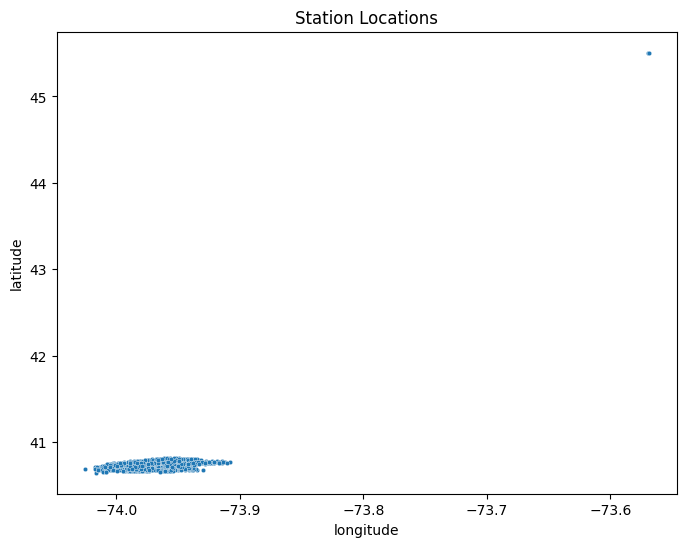

In [11]:
# Quick visualization before filtering
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=stations, x='longitude', y='latitude', s=10)
plt.title('Station Locations')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

We see some outliers and decide to remove them

In [12]:
# Heal obviously swapped coordinates (latitude < -70 and longitude > 40)
swapped_mask = (stations['latitude'] < -70) & (stations['longitude'] > 40)
if swapped_mask.any():
    stations.loc[swapped_mask, ['latitude', 'longitude']] = (
        stations.loc[swapped_mask, ['longitude', 'latitude']].values
    )

# Strict NYC bounds to match the spec above
stations = stations[
    (stations['latitude'] >= 40.60) & (stations['latitude'] <= 40.90) &
    (stations['longitude'] >= -74.05) & (stations['longitude'] <= -73.90)
]
print(stations.shape)
stations.describe()

(816, 3)


start_station_id    latitude   longitude
count        816.000000  816.000000  816.000000
mean        2331.263480   40.732937  -73.971867
std         1436.293496    0.040241    0.024200
min           72.000000   40.646538  -74.025353
25%          455.750000   40.697902  -73.990708
50%         3166.500000   40.732253  -73.974599
75%         3468.250000   40.764398  -73.953427
max         3721.000000   40.814394  -73.907744

### 2.2 Spatial Distribution of Stations


After removing the outlier coordinates, the plot now correctly shows all stations concentrated around Manhattan, Brooklyn, and Jersey City.
This cleaned dataset is now ready for spatial clustering.

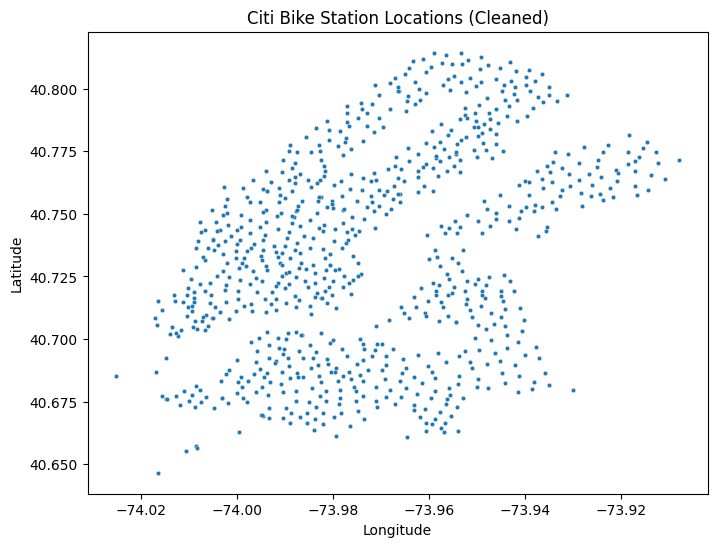

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=stations, x='longitude', y='latitude', s=10)
plt.title('Citi Bike Station Locations (Cleaned)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We verify that the cleaned station dataset has no missing values and realistic coordinate ranges (latitude ~40.6–40.9, longitude ~−74.05 to −73.90).

In [14]:
print(stations.isna().sum())
print(stations.describe())

start_station_id    0
latitude            0
longitude           0
dtype: int64
       start_station_id    latitude   longitude
count        816.000000  816.000000  816.000000
mean        2331.263480   40.732937  -73.971867
std         1436.293496    0.040241    0.024200
min           72.000000   40.646538  -74.025353
25%          455.750000   40.697902  -73.990708
50%         3166.500000   40.732253  -73.974599
75%         3468.250000   40.764398  -73.953427
max         3721.000000   40.814394  -73.907744


Finally, we decided to create a pickup density heat map  and visualize the stations for better understanding

In [15]:
import folium

map_center = [
    stations['latitude'].mean(),
    stations['longitude'].mean()
]

m_stations = folium.Map(location=map_center, zoom_start=12)

for idx, row in stations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        popup=f"Station ID: {int(row['start_station_id'])}"
    ).add_to(m_stations)

m_stations

In [16]:
from folium.plugins import HeatMap

# 1. Calculate pickup counts
pickup_counts = data.groupby('start_station_id').size().to_frame(name='pickup_count')

# 2. Merge counts with station data (uses renamed columns: latitude/longitude)
stations_data = stations.merge(
    pickup_counts,
    on='start_station_id',
    how='inner'
)

# 3. Build (lat, lon, weight) tuples for the heatmap
heat_data = stations_data[[
    'latitude',
    'longitude',
    'pickup_count'
]].values.tolist()

# 4. Create a new base ma
m_heatmap = folium.Map(location=map_center, zoom_start=12)

# 5. Add the HeatMap layer
HeatMap(
    heat_data,
    radius=15,
    blur=10,
    min_opacity=0.3
).add_to(m_heatmap)

# 6. Display the heatmap
m_heatmap

The column usertype contains string values such as "Subscriber" and "Customer".
It was converted into a categorical type to reduce memory usage and prepare it for future encoding if needed.

In [17]:
data['usertype'] = data['usertype'].astype('category')
print(data['usertype'].value_counts())

usertype
Subscriber    15614825
Customer       1933514
Name: count, dtype: int64


### 2.3 Temporal usage patterns


#### 2.3.1 Prepare time-of-day features

Add hour of day and ordered day-of-week fields to enable time-based analyses and comparisons across weekdays/weekends.

In [18]:
# 1. Extract hour and day of week
data['start_hour'] = data['starttime'].dt.hour
data['day_of_week'] = data['starttime'].dt.day_name()

# 2. IMPORTANT: Order the days of the week correctly
# If we don't do this, they will be plotted alphabetically.
week_order = [
    "Monday", 
    "Tuesday", 
    "Wednesday", 
    "Thursday", 
    "Friday", 
    "Saturday", 
    "Sunday"
]

data['day_of_week'] = pd.Categorical(
    data['day_of_week'], 
    categories=week_order, 
    ordered=True
)

print("Data prepared with 'start_hour' and 'day_of_week' columns.")

Data prepared with 'start_hour' and 'day_of_week' columns.


#### 2.3.2 Advanced Heatmap Analysis: Subscribers vs Customers

This code creates an advanced side-by-side heatmap visualization that provides the most insightful comparison between different user types. It plots **Subscribers** and **Customers** next to each other for easy comparison of their ride patterns.

Plotting heatmaps...


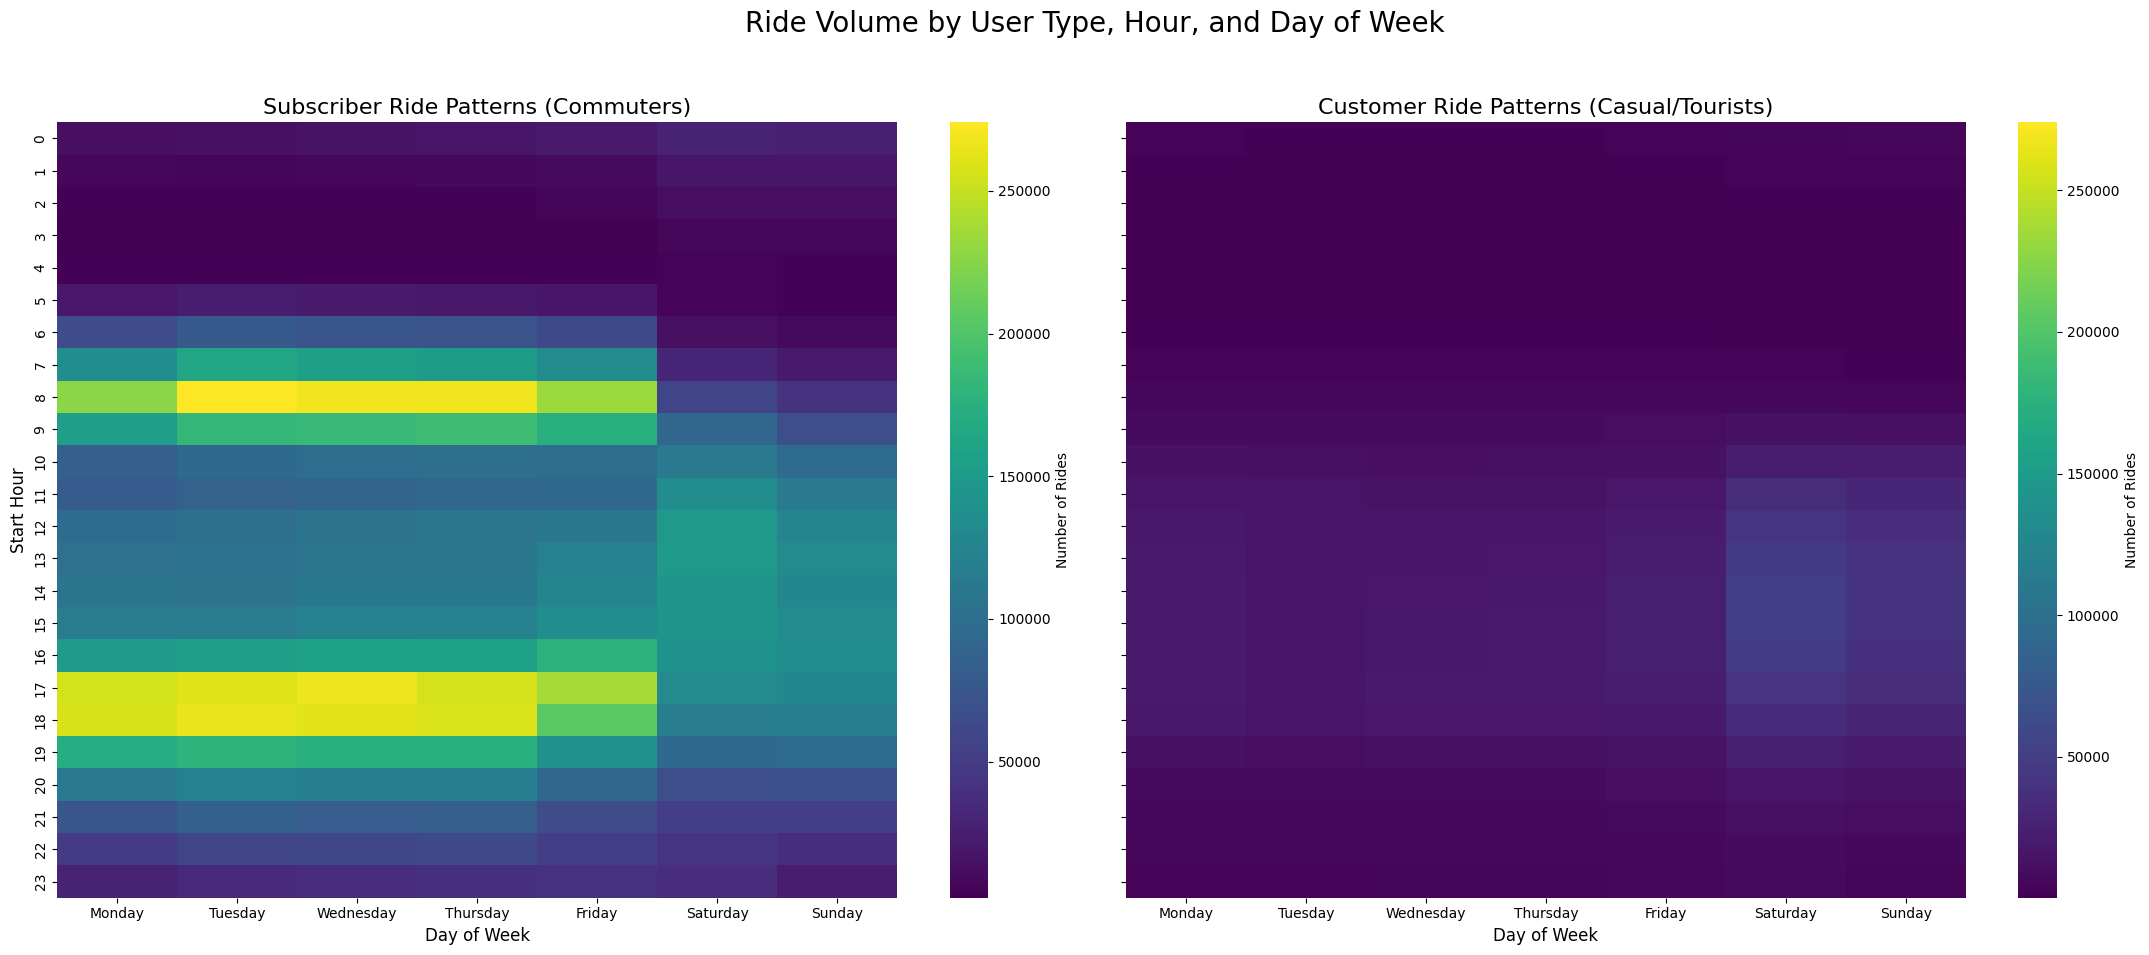

In [19]:

# We need to aggregate the data for each user type.

# [cite_start]Filter for Subscribers [cite: 120-134]
data_subscribers = data[data['usertype'] == 'Subscriber']
# Filter for Customers (or your other user type)
data_customers = data[data['usertype'] == 'Customer'] 

# Create a pivot table (matrix) for each
# We use observed=True to handle the categorical 'day_of_week'
pivot_sub = data_subscribers.pivot_table(
    index='start_hour',
    columns='day_of_week',
    values='bikeid',  # We can count any column, like 'bikeid'
    aggfunc='count',
    observed=True
).fillna(0) # Fill non-existent rides with 0

pivot_cust = data_customers.pivot_table(
    index='start_hour',
    columns='day_of_week',
    values='bikeid',
    aggfunc='count',
    observed=True
).fillna(0)

# --- 2. Find the Global Max for Color Scaling ---
# This ensures both plots use the same color scale for a fair comparison
vmax = max(pivot_sub.max().max(), pivot_cust.max().max())

# --- 3. Create the Side-by-Side Plot ---
print("Plotting heatmaps...")

# Create a figure with two subplots (axes)
fig, (ax1, ax2) = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(22, 10), 
    sharey=True # Make them share the same y-axis (hours)
)

# Plot 1: Subscribers
sns.heatmap(
    pivot_sub, 
    ax=ax1,              # Plot on the first axis
    cmap="viridis",      # Color map
    vmax=vmax,           # Set the shared max color value
    cbar_kws={'label': 'Number of Rides'} # Label for the color bar
)
ax1.set_title("Subscriber Ride Patterns (Commuters)", fontsize=16)
ax1.set_xlabel("Day of Week", fontsize=12)
ax1.set_ylabel("Start Hour", fontsize=12)

# Plot 2: Customers
sns.heatmap(
    pivot_cust, 
    ax=ax2,              # Plot on the second axis
    cmap="viridis",
    vmax=vmax,
    cbar_kws={'label': 'Number of Rides'}
)
ax2.set_title("Customer Ride Patterns (Casual/Tourists)", fontsize=16)
ax2.set_xlabel("Day of Week", fontsize=12)
ax2.set_ylabel("") # No need to repeat the y-label

# Add a main title for the whole figure
fig.suptitle("Ride Volume by User Type, Hour, and Day of Week", fontsize=20)

# Clean up the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Make space for the suptitle

# Show the plot
plt.show()

**What This Reveals:**
- **Subscribers** show clear commuter patterns with peaks during rush hours (8-9 AM, 5-6 PM) on weekdays
- **Customers** display more leisure-oriented patterns with activity concentrated on weekends and midday hours
- The synchronized color scale allows for direct visual comparison of ride volumes between user types

### 2.4 Popular Station-to-Station Routes

To understand movement patterns within the Citi Bike system, we examined the most frequently occurring station-to-station connections. Each trip was mapped to a unique route defined by its origin and destination station IDs. By aggregating all trips by these pairs, we identified the ten most common routes. These high-frequency routes reveal the most travelled corridors in the network and provide operational insight into key mobility flows.

The bar chart below visualizes the top 10 most common routes, where each bar represents a start–end station pair and its length corresponds to the total number of trips taken along that path.


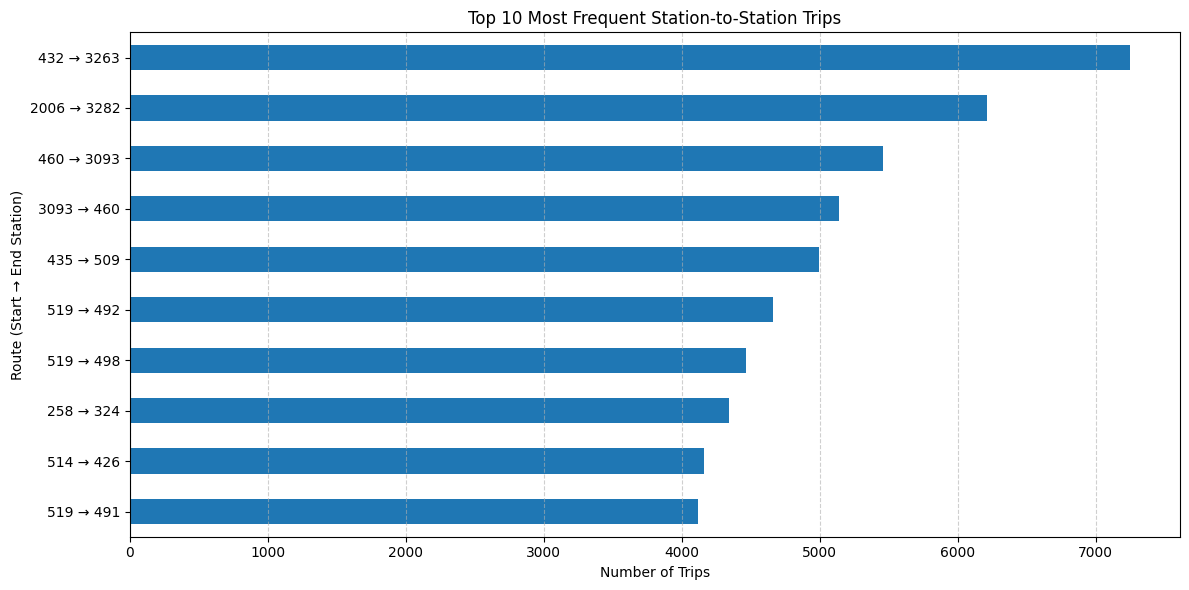

In [20]:
# --- Step 1: Prepare mapping from station_id → station_name (if available) ---
name_cols = [c for c in stations.columns if "name" in c.lower()]
id_cols   = [c for c in stations.columns if "id" in c.lower()]

station_id_col   = id_cols[0]
station_name_col = name_cols[0] if name_cols else None

if station_name_col:
    id_to_name = stations.set_index(station_id_col)[station_name_col].to_dict()
else:
    id_to_name = {int(x): str(int(x)) for x in stations[station_id_col].dropna()}

# --- Step 2: Filter trip data to only include valid stations ---
valid_ids = stations[station_id_col].dropna().astype("Int64").unique()
mask = (
    data["start_station_id"].astype("Int64").isin(valid_ids) &
    data["end_station_id"].astype("Int64").isin(valid_ids)
)
data_nyc = data[mask]

# --- Step 3: Compute top 10 station-to-station routes (exclude same-station trips) ---
data_nyc_routes = data_nyc[data_nyc["start_station_id"] != data_nyc["end_station_id"]]

top10_pairs = (
    data_nyc_routes[["start_station_id", "end_station_id"]]
    .astype("Int64")
    .value_counts()
    .head(10)
)

top10_df = top10_pairs.reset_index(name="trip_count")

# --- Step 4: Create readable labels ---
def station_label(sid):
    sid_int = int(sid)
    return str(id_to_name.get(sid_int, sid_int))

top10_df["start_name"] = top10_df["start_station_id"].apply(station_label)
top10_df["end_name"]   = top10_df["end_station_id"].apply(station_label)
top10_df["route"]      = top10_df["start_name"] + " → " + top10_df["end_name"]
top10_df = top10_df.set_index("route")

# --- Step 5: Plot ---
plt.figure(figsize=(12, 6))
top10_df["trip_count"].sort_values().plot(kind="barh")

plt.title("Top 10 Most Frequent Station-to-Station Trips")
plt.xlabel("Number of Trips")
plt.ylabel("Route (Start → End Station)")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### 2.5 Trip duration distributions

Visualizes trip duration in minutes using a log-scale histogram and a by-usertype boxplot (filtered to < 3 hours) to reveal central tendency, spread, and differences between Subscribers and Customers.

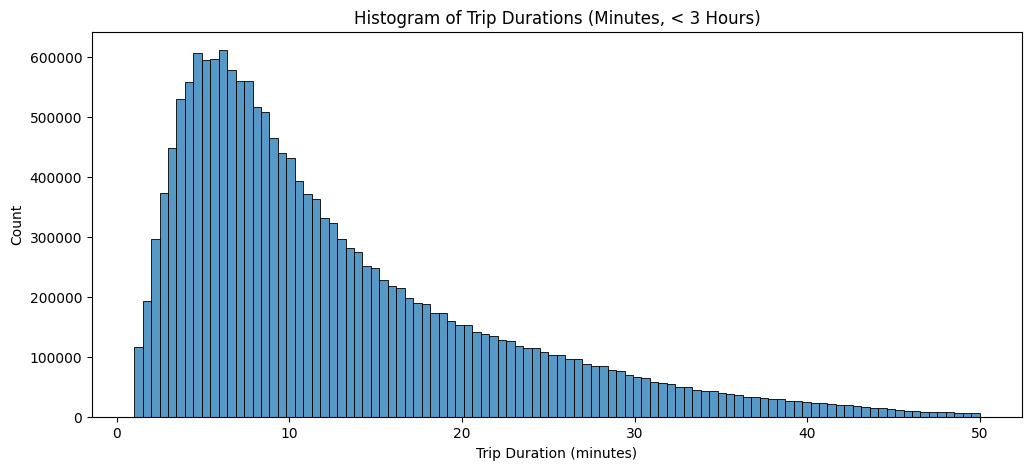

In [21]:
# 1. Create a 'tripduration_min' column
data['tripduration_min'] = data['tripduration'] / 60

# 2. Filter out extremely long trips (e.g., > 3 hours or 180 minutes)
reasonable_trips = data[data['tripduration_min'] < 50]

# 3. Plot the histogram in minutes (no log scale)
plt.figure(figsize=(12, 5))

sns.histplot(reasonable_trips['tripduration_min'], bins=100)

plt.title('Histogram of Trip Durations (Minutes, < 3 Hours)')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Count')
plt.show()

This shows that: Trip durations are short and right‑skewed: most rides last 5–15 minutes, with long trips rare.

### 2.6 Hourly pattern by day of week

Line chart of hourly ride counts split by weekday to compare intra-day patterns across days (e.g., commute peaks on weekdays vs smoother curves on weekends).

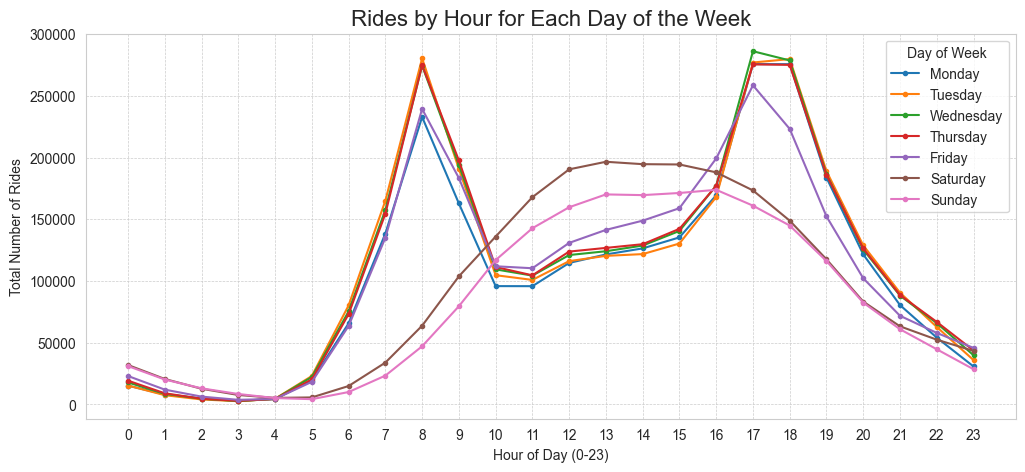

In [22]:
# Set a style for the plot
sns.set_style("whitegrid")

hourly_pivot = data.pivot_table(
    index='start_hour',
    columns='day_of_week',
    values='bikeid',  # Any column can be used for counting
    aggfunc='count',
    observed=True    # Use for categorical 'day_of_week'
).fillna(0) # Fill any missing hour/day combos with 0 rides

# --- 2. Plot the Pivot Table ---
# When you call .plot() on a DataFrame, pandas automatically
# plots each column as a separate line with a different color.

hourly_pivot.plot(
    kind='line',
    figsize=(12, 5), # Make the plot wider
    marker='.',       # Add markers to the data points
)

# --- 3. Customize the Plot ---
plt.title('Rides by Hour for Each Day of the Week', fontsize=16)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Total Number of Rides')
plt.xticks(range(0, 24)) # Ensure all 24 hours are ticked
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Day of Week') # Add a title to the legend
plt.show()

For rides by hour for each day of the week: Weekdays exhibit a pronounced bimodal pattern with peaks around 8–9 AM and 5–6 PM, reflecting strong commuter behavior aligned with standard work hours. The peaks are consistently higher Monday–Friday, while activity dips sharply in early mornings and late nights. Weekends break this pattern, showing a flatter curve with a broad midday/afternoon rise (roughly 11 AM–4 PM) and much weaker rush-hour spikes, indicating more leisure-oriented usage.

---

## Section 3: Clustering

### K-Means

In this section, we cluster Citi Bike stations spatially to group nearby locations together.
These clusters will later serve as the basis for demand prediction.
We apply two unsupervised learning algorithms discussed in class —> K-Means and DBSCAN, and compare their results.
Clustering helps reduce the complexity of the system by aggregating stations with similar geographic positions and potentially similar demand profiles.

In [23]:
# To ensure both variables contribute equally to distance calculations, we standardize them using StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale latitude and longitude before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(stations[['latitude', 'longitude']])

We start with K-Means clustering, which partitions the stations into K groups based on Euclidean distance.
The number of clusters (K) must be chosen carefully, so we use the Elbow Method to identify an appropriate value.
The project requires at least 20 clusters, but we test multiple K values to justify our choice.

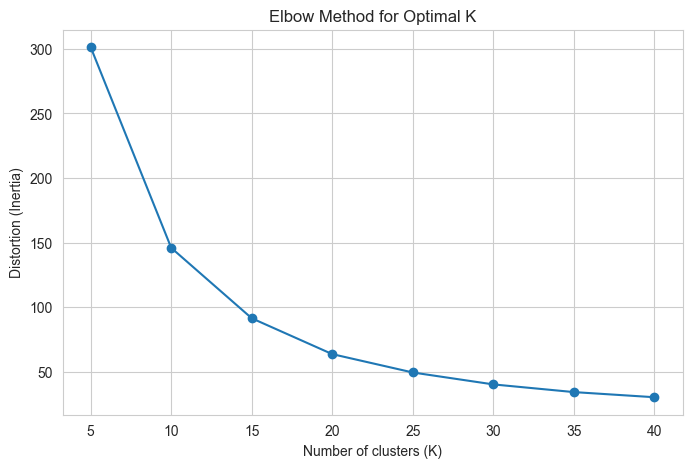

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K_values = range(5, 41, 5)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_values, distortions, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion (Inertia)')
plt.show()

The Elbow Method plot shows how the total within-cluster variance (distortion) decreases as K increases.
We look for the “elbow point,” where adding more clusters only slightly improves the fit.
Based on the plot, we select K = 20, which also satisfies the project requirement of at least 20 clusters.

In [25]:
kmeans = KMeans(n_clusters=20, random_state=42)
stations['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

We visualize the 20 spatial clusters generated by K-Means.
Each color represents a group of geographically close stations that likely serve similar demand areas.

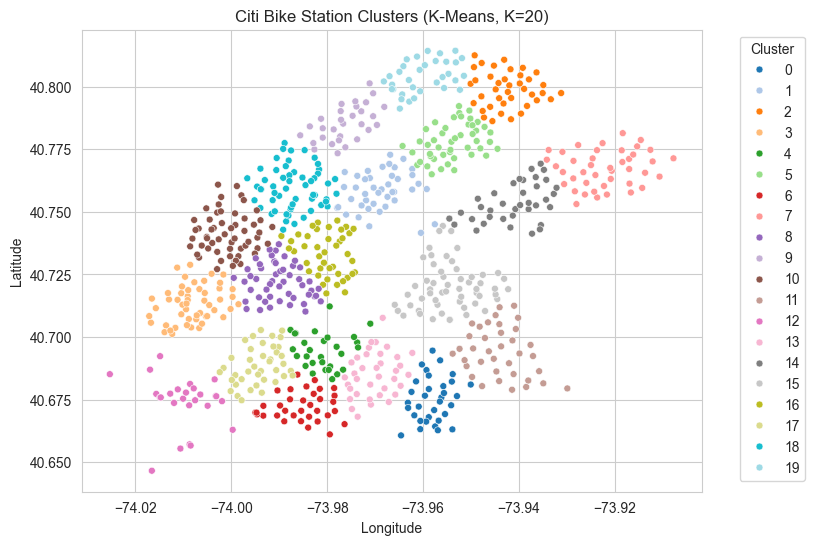

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=stations, x='longitude', y='latitude',
    hue='cluster_kmeans', palette='tab20', s=25
)
plt.title('Citi Bike Station Clusters (K-Means, K=20)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The K-Means clustering successfully groups nearby stations into clear geographic regions. This is an interactive heatmap to help us understand the exact distribution

In [27]:
import folium
from folium.plugins import HeatMap
import matplotlib.cm as cm
import matplotlib.colors as mcolors

m_clusters = folium.Map(location=map_center, zoom_start=12)

# Determine number of clusters from K-Means
k = int(stations['cluster_kmeans'].nunique())
palette = cm.get_cmap('tab20', max(k, 1))

# --- 2. Add Colored Markers for Each Station ---
for _, row in stations.iterrows():
    cluster_id = int(row['cluster_kmeans'])

    # Convert RGBA to HEX for Folium
    rgba = palette(cluster_id % max(k, 1))
    cluster_color = mcolors.to_hex(rgba)

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.8,
        popup=f"Station ID: {int(row['start_station_id'])}<br>Cluster: {cluster_id}"
    ).add_to(m_clusters)

# --- 3. Display the Map ---
m_clusters

/var/folders/9r/y31p_9qx7rdf4xj9dlm3mxm80000gn/T/ipykernel_16215/3371874177.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab20', max(k, 1))


This map groups nearby stations into neighborhoods. You can see the tightest, most colorful clusters packed into Midtown and Downtown Manhattan, where stations are close together and demand is dense. As you move into Brooklyn and Jersey City, the clusters spread out and get larger, matching the lower station density there. The shapes mostly follow the rivers and major roads, and there are a few small “hotspot” clusters near bridges and waterfronts—places where people are likely switching to ferries or crossing between boroughs. Overall, it looks like a very city-shaped pattern of commuting and everyday trips.

---

### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is another algorithm covered in class.
Unlike K-Means, DBSCAN does not require choosing the number of clusters K.
Instead, it groups stations based on spatial density, allowing irregular shapes and identifying outliers.

In [28]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN to the standardized coordinates
dbscan = DBSCAN(eps=0.05, min_samples=5)
stations['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

# Count how many clusters were found (excluding noise)
unique_labels = np.unique(stations['cluster_dbscan'])
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
print(f"Number of clusters found: {num_clusters}")

Number of clusters found: 0


Initially, DBSCAN detected no clusters (Number of clusters found: 0), which means that the chosen parameters were too strict.
DBSCAN’s performance is highly sensitive to its parameters, especially eps (the neighborhood radius).
To understand how this parameter affects the results, we test several eps values while keeping min_samples fixed at 5.
This helps identify a range that produces meaningful clusters without merging everything into one large group.

In [29]:
for eps in [0.05, 0.1, 0.2, 0.3, 0.5]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"eps={eps} → clusters found: {num_clusters}")

eps=0.05 → clusters found: 0
eps=0.1 → clusters found: 39
eps=0.2 → clusters found: 1
eps=0.3 → clusters found: 1
eps=0.5 → clusters found: 1


With very small eps (0.05), DBSCAN is too restrictive and fails to form clusters.
When eps=0.1, the algorithm identifies 39 distinct clusters, which seems reasonable and consistent with the expected spatial diversity across New York City.
Larger values (≥0.2) merge nearly all points into one cluster, losing spatial separation.

Therefore, we select eps = 0.1 as a suitable balance. It identifies multiple meaningful clusters without over-merging or over-fragmenting the data.
Next, we visualize the results to inspect how these clusters are distributed geographically.

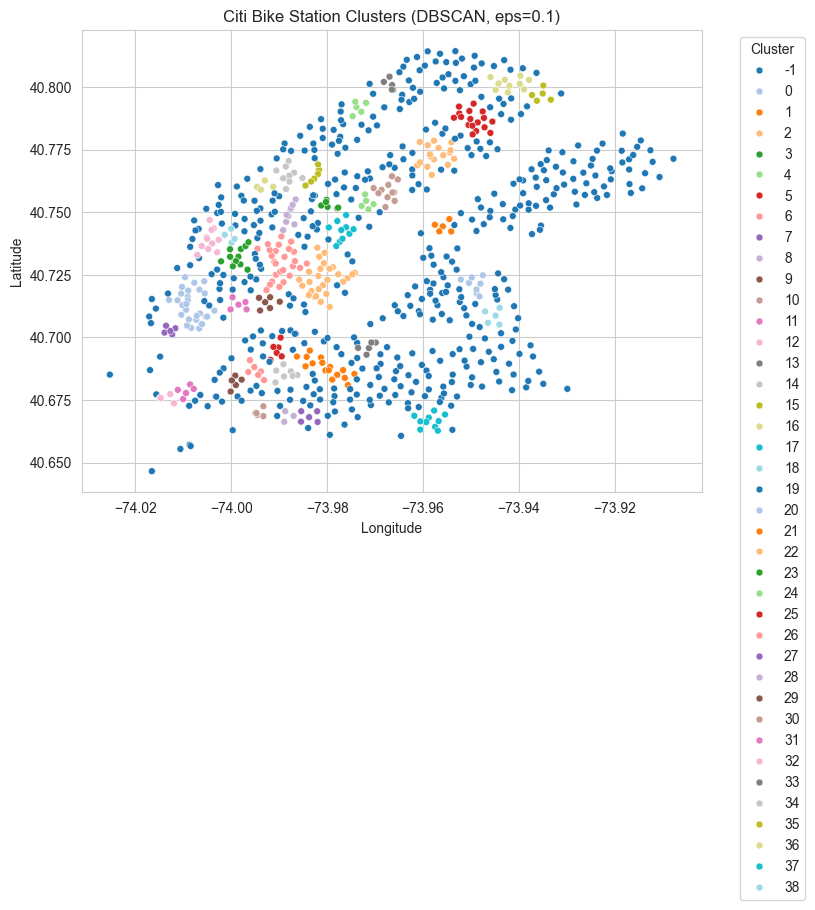

In [30]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
stations['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=stations,
    x='longitude', y='latitude',
    hue='cluster_dbscan',
    palette='tab20', s=25
)
plt.title('Citi Bike Station Clusters (DBSCAN, eps=0.1)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The interactive map confirms the spatial patterns seen in the scatter plot: dense, contiguous clusters throughout Manhattan, with smaller, sparser groups in Brooklyn and Jersey City.
Noise points are isolated stations (gray) that DBSCAN excludes from any dense region.
We keep DBSCAN here for interpretation, but for the prediction tasks we proceed with K-Means (K=20) to ensure a fixed number of geographic regions.

In [31]:
import folium
from folium.plugins import MarkerCluster
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Center the map on the average station location
center_lat = stations['latitude'].mean()
center_lon = stations['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')

# Build a color map for clusters (use tab20; gray for noise = -1)
labels = stations['cluster_dbscan'].values
unique_labels = sorted(set(labels))

# Prepare a discrete palette for non-noise clusters
n_clusters_no_noise = len([l for l in unique_labels if l != -1])
palette = cm.get_cmap('tab20', max(n_clusters_no_noise, 1))

cluster_to_color = {}
idx = 0
for l in unique_labels:
    if l == -1:
        cluster_to_color[l] = '#9e9e9e'  # gray for noise
    else:
        rgba = palette(idx)
        cluster_to_color[l] = mcolors.to_hex(rgba)
        idx += 1

# Add one FeatureGroup per cluster so they can be toggled
for l in unique_labels:
    name = f'Cluster {l}' if l != -1 else 'Noise (-1)'
    fg = folium.FeatureGroup(name=name, show=(l != -1))  # show non-noise by default
    subset = stations[stations['cluster_dbscan'] == l]

    # Use small circle markers for performance
    for _, row in subset.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color=cluster_to_color[l],
            fill=True,
            fill_opacity=0.9,
            opacity=0.8,
        ).add_to(fg)
    fg.add_to(m)

# (Optional) Add approximate centroids of each non-noise cluster
centroids = (
    stations[stations['cluster_dbscan'] != -1]
    .groupby('cluster_dbscan')[['latitude', 'longitude']]
    .mean()
    .reset_index()
)

centroid_fg = folium.FeatureGroup(name='Cluster centroids', show=False)
for _, r in centroids.iterrows():
    folium.Marker(
        location=[r['latitude'], r['longitude']],
        tooltip=f"Cluster {int(r['cluster_dbscan'])} centroid",
        icon=folium.Icon(color='blue', icon='flag')
    ).add_to(centroid_fg)
centroid_fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m


/var/folders/9r/y31p_9qx7rdf4xj9dlm3mxm80000gn/T/ipykernel_16215/1881145649.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab20', max(n_clusters_no_noise, 1))


K-Means vs DBSCAN - what we learned

- K-Means (K=20) gives clean, evenly shaped regions that are easy to interpret and use downstream. It works well in dense areas like Manhattan and guarantees exactly 20 clusters, which we need for later modeling.
- DBSCAN adapts to density: it can find irregular shapes and mark isolated stations as noise. With eps=0.1 here, it separated many meaningful pockets while flagging sparse locations at the edges.
- Trade‑off: K-Means is stable and predictable (fixed K), but it can cut through natural boundaries. DBSCAN respects density structure and outliers, but results depend on sensitive parameters and can vary with station coverage.

Decision for this project: we keep DBSCAN for insight into outliers/hotspots and qualitative checks, but proceed with K-Means (K=20) for the modeling pipeline, since it gives a consistent partition for aggregating demand and forecasting.

---

## Section 4: Prediction Challenge

### From the 20 Clusters we used at K-Means, we choose the 2 biggest and decide to work with them for the prediction model. The reason is that the bigger the cluster the more data points we have, and this will make our prediction model better.

### 4.1 Focus on the two largest clusters

We proceed with clusters **18** (Midtown/West Side) and **15** (Downtown/Williamsburg). These clusters each contain 56 Citi Bike stations, making them the densest coverage areas in our spatial analysis.

In [32]:
# Attach cluster assignments to each trip and build hourly demand per cluster
cluster_map = stations[['start_station_id', 'cluster_kmeans']].copy()
data_clusters = data.merge(cluster_map, on='start_station_id', how='inner')

# Keep only the two largest clusters (15 and 18)
target_clusters = data_clusters[data_clusters['cluster_kmeans'].isin([15, 18])].copy()
target_clusters['start_hour_ts'] = target_clusters['starttime'].dt.floor('H')

hourly_demand = (
    target_clusters
    .groupby(['cluster_kmeans', 'start_hour_ts'])
    .size()
    .rename('trip_count')
    .reset_index()
    .sort_values(['cluster_kmeans', 'start_hour_ts'])
)

hourly_demand.head()


/var/folders/9r/y31p_9qx7rdf4xj9dlm3mxm80000gn/T/ipykernel_16215/210861530.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  target_clusters['start_hour_ts'] = target_clusters['starttime'].dt.floor('H')


cluster_kmeans       start_hour_ts  trip_count
0              15 2018-01-01 00:00:00           8
1              15 2018-01-01 01:00:00          10
2              15 2018-01-01 02:00:00          10
3              15 2018-01-01 03:00:00           4
4              15 2018-01-01 04:00:00           1

### 4.2 Feature engineering for hourly demand

To feed the prediction models, we enrich the hourly counts with calendar variables (hour, weekday, month) and lagged demand features (previous hour and previous day). Lags help capture short-term momentum while the calendar fields encode commuter patterns.

Starting here, we enforce the project’s temporal split: **January–October 2018** observations feed the models (train set) and the remaining **November–December 2018** hours form the out-of-sample test window that we will forecast.


#### 4.3.1 Build the pickup feature table

The next cell aggregates pickups for clusters 15 and 18 at an hourly cadence, enriches them with calendar fields (hour, weekday, month, weekend flag), and adds 1-hour and 24-hour lag features. It also tags each row as train (Jan–Oct) or test (Nov–Dec) so that all downstream models respect the chronological split.


In [33]:
# Calendar features + lagged demand (with explicit train/test split)
train_cutoff = pd.Timestamp('2018-11-01 00:00:00')

hourly_features = hourly_demand.copy()
hourly_features['hour'] = hourly_features['start_hour_ts'].dt.hour
hourly_features['day_of_week'] = hourly_features['start_hour_ts'].dt.dayofweek  # Monday=0
hourly_features['month'] = hourly_features['start_hour_ts'].dt.month
hourly_features['is_weekend'] = (hourly_features['day_of_week'] >= 5).astype(int)

for lag in [1, 24]:
    hourly_features[f'lag_{lag}'] = (
        hourly_features
        .groupby('cluster_kmeans')['trip_count']
        .shift(lag)
    )

# Drop rows without full lag history and tag the calendar split
hourly_features = hourly_features.dropna().reset_index(drop=True)
hourly_features['hour_ts'] = hourly_features['start_hour_ts']
hourly_features['data_split'] = np.where(hourly_features['hour_ts'] < train_cutoff, 'train', 'test')

feature_cols = ['hour', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_24']
hourly_features.head()


cluster_kmeans       start_hour_ts  trip_count  hour  day_of_week  month  \
0              15 2018-01-02 01:00:00           2     1            1      1   
1              15 2018-01-02 04:00:00           1     4            1      1   
2              15 2018-01-02 05:00:00           5     5            1      1   
3              15 2018-01-02 06:00:00          20     6            1      1   
4              15 2018-01-02 07:00:00          37     7            1      1   

   is_weekend  lag_1  lag_24             hour_ts data_split  
0           0    1.0     8.0 2018-01-02 01:00:00      train  
1           0    2.0    10.0 2018-01-02 04:00:00      train  
2           0    1.0    10.0 2018-01-02 05:00:00      train  
3           0    5.0     4.0 2018-01-02 06:00:00      train  
4           0   20.0     1.0 2018-01-02 07:00:00      train

### 4.3 Modeling approach

We formulate next-day demand prediction as a supervised regression problem on hourly aggregates. To identify the best-performing model, we compare five different approaches:

1. **Linear Regression**: A baseline linear model that learns linear relationships between features and target
2. **Gradient Boosting**: An ensemble method that builds models sequentially to correct previous errors
3. **Random Forest**: An ensemble of decision trees that learns nonlinear relationships between the engineered features (hour of day, weekday, month, weekend flag, 1‑hour lag, 24‑hour lag)
4. **ARIMA**: A time series model that captures autoregressive and moving average patterns
5. **SARIMA**: A seasonal ARIMA model that additionally accounts for seasonal patterns (24-hour cycles)

All models are trained strictly on data before **1 Nov 2018** and evaluated on the full **Nov–Dec 2018** horizon, without shuffling, so the models see only historical information. The same setup is used for both pickups and dropoffs. The comparison evaluates each model using MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and R² (coefficient of determination) metrics, providing both aggregate summaries and detailed breakdowns by cluster and flow type.


In [34]:
# === Comprehensive Model Comparison: Linear Regression, Gradient Boosting, Random Forest, ARIMA, SARIMA ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Ensure we have the required data
if 'cluster_hourly' not in globals() or cluster_hourly is None:
    if 'hourly_demand' in globals() and 'hourly_dropoffs' in globals():
        pickup_actuals = (
            hourly_demand[['cluster_kmeans', 'start_hour_ts', 'trip_count']]
            .rename(columns={'cluster_kmeans': 'cluster_id', 'start_hour_ts': 'datetime', 'trip_count': 'pickups'})
        )
        dropoff_actuals = (
            hourly_dropoffs[['cluster_kmeans', 'stop_hour_ts', 'arrival_count']]
            .rename(columns={'cluster_kmeans': 'cluster_id', 'stop_hour_ts': 'datetime', 'arrival_count': 'dropoffs'})
        )
        cluster_hourly = (
            pickup_actuals.merge(dropoff_actuals, on=['cluster_id', 'datetime'], how='outer')
            .fillna(0.0).sort_values(['cluster_id', 'datetime']).reset_index(drop=True)
        )
        cluster_hourly['datetime'] = pd.to_datetime(cluster_hourly['datetime'])
    else:
        raise ValueError("Missing hourly_demand/hourly_dropoffs. Rerun section 4.4 first.")

clusters_to_compare = [15, 18]
feature_cols = ['hour', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_24']
train_cutoff = pd.Timestamp('2018-11-01 00:00:00')

# Prepare features for ML models
if 'hourly_features' not in globals():
    raise ValueError("Missing hourly_features. Rerun section 4.4 first.")

# Storage for all model results
all_results = []

print("Training and evaluating all models...")

# For each cluster and flow (pickups/dropoffs)
for cluster_id in clusters_to_compare:
    for flow_name in ['pickups', 'dropoffs']:
        if flow_name == 'pickups':
            features_df = hourly_features.copy()
            value_col = 'trip_count'
            time_col = 'hour_ts'
            endog_col = 'pickups'
        else:
            features_df = dropoff_features.copy()
            value_col = 'arrival_count'
            time_col = 'hour_ts'
            endog_col = 'dropoffs'
        
        cluster_features = (
            features_df[features_df['cluster_kmeans'] == cluster_id]
            .sort_values(time_col)
            .reset_index(drop=True)
        )
        
        # Ensure datetime column exists for time series models
        if 'datetime' not in cluster_features.columns:
            cluster_features['datetime'] = pd.to_datetime(cluster_features[time_col])
        
        train_df = cluster_features[cluster_features[time_col] < train_cutoff].copy()
        test_df = cluster_features[cluster_features[time_col] >= train_cutoff].copy()
        
        if train_df.empty or test_df.empty:
            continue
        
        X_train = train_df[feature_cols].values
        y_train = train_df[value_col].values
        X_test = test_df[feature_cols].values
        y_test = test_df[value_col].values
        
        # === 1. Linear Regression ===
        try:
            lr_model = LinearRegression()
            lr_model.fit(X_train, y_train)
            lr_pred = lr_model.predict(X_test)
            lr_pred = np.maximum(0, lr_pred)  # Ensure non-negative predictions
            
            lr_mae = mean_absolute_error(y_test, lr_pred)
            lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
            lr_r2 = max(0.0, r2_score(y_test, lr_pred)) if not np.isnan(r2_score(y_test, lr_pred)) else 0.0
            
            all_results.append({
                'model': 'Linear Regression',
                'cluster': cluster_id,
                'flow': flow_name,
                'MAE': lr_mae,
                'RMSE': lr_rmse,
                'R2': lr_r2
            })
        except Exception as e:
            print(f"Linear Regression failed for cluster {cluster_id}, {flow_name}: {e}")
        
        # === 2. Gradient Boosting ===
        try:
            gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
            gb_model.fit(X_train, y_train)
            gb_pred = gb_model.predict(X_test)
            gb_pred = np.maximum(0, gb_pred)
            
            gb_mae = mean_absolute_error(y_test, gb_pred)
            gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
            gb_r2 = max(0.0, r2_score(y_test, gb_pred)) if not np.isnan(r2_score(y_test, gb_pred)) else 0.0
            
            all_results.append({
                'model': 'Gradient Boosting',
                'cluster': cluster_id,
                'flow': flow_name,
                'MAE': gb_mae,
                'RMSE': gb_rmse,
                'R2': gb_r2
            })
        except Exception as e:
            print(f"Gradient Boosting failed for cluster {cluster_id}, {flow_name}: {e}")
        
        # === 3. Random Forest ===
        try:
            rf_model = RandomForestRegressor(n_estimators=200, max_depth=25, random_state=42, n_jobs=-1)
            rf_model.fit(X_train, y_train)
            rf_pred = rf_model.predict(X_test)
            rf_pred = np.maximum(0, rf_pred)
            
            rf_mae = mean_absolute_error(y_test, rf_pred)
            rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
            rf_r2 = max(0.0, r2_score(y_test, rf_pred)) if not np.isnan(r2_score(y_test, rf_pred)) else 0.0
            
            all_results.append({
                'model': 'Random Forest',
                'cluster': cluster_id,
                'flow': flow_name,
                'MAE': rf_mae,
                'RMSE': rf_rmse,
                'R2': rf_r2
            })
        except Exception as e:
            print(f"Random Forest failed for cluster {cluster_id}, {flow_name}: {e}")
        
        # === 4. ARIMA ===
        try:
            # Use time_col instead of 'datetime'
            train_ts = train_df.set_index(time_col)[value_col].asfreq('H').fillna(0)
            test_ts = test_df.set_index(time_col)[value_col]
            test_index = pd.date_range(start=test_ts.index.min(), end=test_ts.index.max(), freq='H')
            
            arima_model = ARIMA(train_ts, order=(2,1,2))
            arima_res = arima_model.fit()
            arima_pred = arima_res.get_prediction(start=test_index.min(), end=test_index.max())
            arima_pred_series = arima_pred.predicted_mean.reindex(test_index, fill_value=0)
            
            # Align with actual test data
            aligned_pred = arima_pred_series.reindex(test_ts.index, method='nearest').fillna(0)
            aligned_pred = np.maximum(0, aligned_pred.values)
            
            arima_mae = mean_absolute_error(test_ts.values, aligned_pred)
            arima_rmse = np.sqrt(mean_squared_error(test_ts.values, aligned_pred))
            arima_r2 = max(0.0, r2_score(test_ts.values, aligned_pred)) if not np.isnan(r2_score(test_ts.values, aligned_pred)) else 0.0
            
            all_results.append({
                'model': 'ARIMA',
                'cluster': cluster_id,
                'flow': flow_name,
                'MAE': arima_mae,
                'RMSE': arima_rmse,
                'R2': arima_r2
            })
        except Exception as e:
            print(f"ARIMA failed for cluster {cluster_id}, {flow_name}: {e}")
        
        # === 5. SARIMA ===
        try:
            # Use time_col instead of 'datetime'
            train_ts = train_df.set_index(time_col)[value_col].asfreq('H').fillna(0)
            test_ts = test_df.set_index(time_col)[value_col]
            test_index = pd.date_range(start=test_ts.index.min(), end=test_ts.index.max(), freq='H')
            
            sarima_model = SARIMAX(train_ts, order=(1,0,1), seasonal_order=(1,1,1,24), 
                                   enforce_stationarity=False, enforce_invertibility=False)
            sarima_res = sarima_model.fit(disp=False)
            sarima_pred = sarima_res.get_prediction(start=test_index.min(), end=test_index.max())
            sarima_pred_series = sarima_pred.predicted_mean.reindex(test_index, fill_value=0)
            
            # Align with actual test data
            aligned_pred = sarima_pred_series.reindex(test_ts.index, method='nearest').fillna(0)
            aligned_pred = np.maximum(0, aligned_pred.values)
            
            sarima_mae = mean_absolute_error(test_ts.values, aligned_pred)
            sarima_rmse = np.sqrt(mean_squared_error(test_ts.values, aligned_pred))
            sarima_r2 = max(0.0, r2_score(test_ts.values, aligned_pred)) if not np.isnan(r2_score(test_ts.values, aligned_pred)) else 0.0
            
            all_results.append({
                'model': 'SARIMA',
                'cluster': cluster_id,
                'flow': flow_name,
                'MAE': sarima_mae,
                'RMSE': sarima_rmse,
                'R2': sarima_r2
            })
        except Exception as e:
            print(f"SARIMA failed for cluster {cluster_id}, {flow_name}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Aggregate by model (average across clusters and flows)
model_summary = (
    results_df
    .groupby('model')[['MAE', 'RMSE', 'R2']]
    .mean()
    .reset_index()
    .sort_values('RMSE')
)

print("\n=== Model Comparison Summary (Average across clusters and flows) ===")
print(model_summary.to_string(index=False))

# === Create Comparison Plots ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = model_summary['model'].values
x_pos = np.arange(len(models))
width = 0.6

# Plot 1: MAE
axes[0].bar(x_pos, model_summary['MAE'], width, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
axes[0].set_title('Model Comparison: MAE', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(model_summary['MAE']):
    axes[0].text(i, v + max(model_summary['MAE']) * 0.01, f'{v:.2f}', 
                ha='center', va='bottom', fontsize=9)

# Plot 2: RMSE
axes[1].bar(x_pos, model_summary['RMSE'], width, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
axes[1].set_title('Model Comparison: RMSE', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(model_summary['RMSE']):
    axes[1].text(i, v + max(model_summary['RMSE']) * 0.01, f'{v:.2f}', 
                ha='center', va='bottom', fontsize=9)

# Plot 3: R²
axes[2].bar(x_pos, model_summary['R2'], width, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('Model Comparison: R²', fontsize=14, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(models, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, max(model_summary['R2']) * 1.2 if max(model_summary['R2']) > 0 else 1])

# Add value labels on bars
for i, v in enumerate(model_summary['R2']):
    axes[2].text(i, v + max(model_summary['R2']) * 0.02 if max(model_summary['R2']) > 0 else 0.02, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# === Detailed breakdown by cluster and flow ===
print("\n=== Detailed Results by Cluster and Flow ===")
detailed_summary = (
    results_df
    .pivot_table(index=['cluster', 'flow'], columns='model', values=['MAE', 'RMSE', 'R2'], aggfunc='mean')
    .round(3)
)
print(detailed_summary)


ModuleNotFoundError: No module named 'statsmodels'

### 4.4 Next-day pickup & dropoff forecasting

Using the engineered features and Gradient Boosting described above, we generate 24-hour trajectories for both departures (pickups) and arrivals (dropoffs) at the end of each day. The model trains only on Jan–Oct data and iteratively predicts every hour of the following day, feeding each hourly prediction back into the lag features so that the entire curve is produced without peeking into future demand.


#### 4.4.1 Hourly dropoff aggregation and feature engineering

We complement the pickup dataset with dropoff (arrival) counts so both flows can be forecasted consistently. The next cells aggregate stop events per hour for clusters 15 and 18, apply the same calendar/lag features, and combine the pickup and dropoff streams into a single structure for model training.


#### 4.4.2 Build the forecasting datasets

The following cells (i) aggregate hourly dropoffs, (ii) attach calendar/lag features for arrivals, and (iii) combine pickup and dropoff series into the `flow_configs` structure that drives model fitting and iterative prediction.

In [ ]:
# Build hourly dropoff counts for the selected clusters
end_cluster_map = cluster_map.rename(columns={'start_station_id': 'end_station_id'})
data_dropoffs = data.merge(end_cluster_map, on='end_station_id', how='inner')

target_dropoffs = data_dropoffs[data_dropoffs['cluster_kmeans'].isin([15, 18])].copy()
target_dropoffs['stop_hour_ts'] = target_dropoffs['stoptime'].dt.floor('H')

hourly_dropoffs = (
    target_dropoffs
    .groupby(['cluster_kmeans', 'stop_hour_ts'])
    .size()
    .rename('arrival_count')
    .reset_index()
    .sort_values(['cluster_kmeans', 'stop_hour_ts'])
)

hourly_dropoffs.head()

cluster_kmeans        stop_hour_ts  arrival_count
0              15 2018-01-01 00:00:00              6
1              15 2018-01-01 01:00:00              6
2              15 2018-01-01 02:00:00              8
3              15 2018-01-01 03:00:00              3
4              15 2018-01-01 04:00:00              2

In [ ]:
# Feature engineering for dropoffs (same calendar + lag structure)
dropoff_features = hourly_dropoffs.copy()
dropoff_features['hour'] = dropoff_features['stop_hour_ts'].dt.hour
dropoff_features['day_of_week'] = dropoff_features['stop_hour_ts'].dt.dayofweek
dropoff_features['month'] = dropoff_features['stop_hour_ts'].dt.month
dropoff_features['is_weekend'] = (dropoff_features['day_of_week'] >= 5).astype(int)

for lag in [1, 24]:
    dropoff_features[f'lag_{lag}'] = (
        dropoff_features
        .groupby('cluster_kmeans')['arrival_count']
        .shift(lag)
    )

dropoff_features = dropoff_features.dropna().reset_index(drop=True)
dropoff_features['hour_ts'] = dropoff_features['stop_hour_ts']
dropoff_features['data_split'] = np.where(dropoff_features['hour_ts'] < train_cutoff, 'train', 'test')

dropoff_features.head()


cluster_kmeans        stop_hour_ts  arrival_count  hour  day_of_week  \
0              15 2018-01-02 04:00:00              1     4            1   
1              15 2018-01-02 05:00:00              5     5            1   
2              15 2018-01-02 06:00:00             17     6            1   
3              15 2018-01-02 07:00:00             33     7            1   
4              15 2018-01-02 08:00:00             52     8            1   

   month  is_weekend  lag_1  lag_24             hour_ts data_split  
0      1           0    2.0     6.0 2018-01-02 04:00:00      train  
1      1           0    1.0     6.0 2018-01-02 05:00:00      train  
2      1           0    5.0     8.0 2018-01-02 06:00:00      train  
3      1           0   17.0     3.0 2018-01-02 07:00:00      train  
4      1           0   33.0     2.0 2018-01-02 08:00:00      train

In [ ]:
# Consolidate pickup/dropoff datasets for the forecasting loop
pickup_features = hourly_features.copy()
pickup_series = hourly_demand[['cluster_kmeans', 'start_hour_ts', 'trip_count']].rename(
    columns={'start_hour_ts': 'hour_ts', 'trip_count': 'value'}
)

dropoff_series = hourly_dropoffs[['cluster_kmeans', 'stop_hour_ts', 'arrival_count']].rename(
    columns={'stop_hour_ts': 'hour_ts', 'arrival_count': 'value'}
)

flow_configs = {
    'pickups': {
        'features': pickup_features,
        'series': pickup_series,
        'time_col': 'hour_ts',
        'value_col': 'trip_count'
    },
    'dropoffs': {
        'features': dropoff_features,
        'series': dropoff_series,
        'time_col': 'hour_ts',
        'value_col': 'arrival_count'
    }
}

flow_configs


{'pickups': {'features':        cluster_kmeans       start_hour_ts  trip_count  hour  day_of_week  \
  0                  15 2018-01-02 01:00:00           2     1            1   
  1                  15 2018-01-02 04:00:00           1     4            1   
  2                  15 2018-01-02 05:00:00           5     5            1   
  3                  15 2018-01-02 06:00:00          20     6            1   
  4                  15 2018-01-02 07:00:00          37     7            1   
  ...               ...                 ...         ...   ...          ...   
  17290              18 2018-12-31 19:00:00          15    19            0   
  17291              18 2018-12-31 20:00:00          14    20            0   
  17292              18 2018-12-31 21:00:00          10    21            0   
  17293              18 2018-12-31 22:00:00          13    22            0   
  17294              18 2018-12-31 23:00:00          10    23            0   
  
         month  is_weekend  lag_1  lag

#### 4.4.3 Train, evaluate, and roll forward forecasts

With both flows prepared, we now (a) tune one Gradient Boosting model per flow/cluster using January–October data only, (b) score the tuned model on the held‑out November–December hours, and (c) iteratively predict the next 24 hours for every test-day boundary. Each hourly prediction feeds back into the lag features so the entire day’s curve is generated without future leakage.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

gb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)

def iterative_forecast(model, history_series, start_time, horizon=24):
    """Roll the model forward hour-by-hour, feeding predictions back into lag features."""
    if len(history_series) == 0:
        raise ValueError("History series must contain observations before the forecast start time.")

    fallback = history_series.mean()
    history = {ts: val for ts, val in history_series.items()}
    rows = []
    current_time = start_time

    for step in range(horizon):
        lag_1_time = current_time - pd.Timedelta(hours=1)
        lag_24_time = current_time - pd.Timedelta(hours=24)
        lag_1 = history.get(lag_1_time, fallback)
        lag_24 = history.get(lag_24_time, fallback)

        features = np.array([[
            current_time.hour,
            current_time.dayofweek,
            current_time.month,
            int(current_time.dayofweek >= 5),
            lag_1,
            lag_24
        ]])

        pred = model.predict(features)[0]
        rows.append({'timestamp': current_time, 'predicted': pred})
        history[current_time] = pred
        current_time += pd.Timedelta(hours=1)

    return pd.DataFrame(rows)


In [ ]:
# Define the clusters to model (the two largest clusters: 15 and 18)
clusters_to_model = [15, 18]

gb_holdout_rows = []
gb_daily_rows = []
forecast_timeseries_rows = []

for flow_name, cfg in flow_configs.items():
    features_df = cfg['features'].copy()
    series_df = cfg['series'].copy()
    time_col = cfg['time_col']
    value_col = cfg['value_col']

    for cluster_id in clusters_to_model:
        cluster_features = (
            features_df[features_df['cluster_kmeans'] == cluster_id]
            .sort_values(time_col)
            .reset_index(drop=True)
        )

        train_df = cluster_features[cluster_features[time_col] < train_cutoff]
        test_df = cluster_features[cluster_features[time_col] >= train_cutoff]

        if train_df.empty or test_df.empty:
            continue

        X_train = train_df[feature_cols].values
        y_train = train_df[value_col].values
        X_test = test_df[feature_cols].values
        y_test = test_df[value_col].values

        gb = GradientBoostingRegressor(random_state=42)
        search = RandomizedSearchCV(
            estimator=gb,
            param_distributions=gb_param_dist,
            n_iter=15,
            cv=tscv,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        search.fit(X_train, y_train)
        best_gb = search.best_estimator_

        holdout_pred = best_gb.predict(X_test)
        r2_holdout = r2_score(y_test, holdout_pred)
        # Cap R² at 0 (negative R² means worse than baseline)
        r2_holdout = max(0.0, r2_holdout) if not np.isnan(r2_holdout) else np.nan
        gb_holdout_rows.append({
            'flow': flow_name,
            'cluster': cluster_id,
            'MAE': mean_absolute_error(y_test, holdout_pred),
            'RMSE': mean_squared_error(y_test, holdout_pred, squared=False),
            'R2': r2_holdout,
            'best_params': search.best_params_
        })

        cluster_series = (
            series_df[series_df['cluster_kmeans'] == cluster_id]
            .sort_values(time_col)
        )
        series_ts = cluster_series.set_index(time_col)['value']

        test_days = (
            cluster_features.loc[cluster_features[time_col] >= train_cutoff, time_col]
            .dt.floor('D')
            .drop_duplicates()
            .sort_values()
        )

        for day in test_days:
            history_series = series_ts[series_ts.index < day]
            actual_next_day = series_ts[
                (series_ts.index >= day) &
                (series_ts.index < day + pd.Timedelta(days=1))
            ]

            if history_series.empty or actual_next_day.empty:
                continue

            forecast_df = iterative_forecast(best_gb, history_series, day)
            actual_df = actual_next_day.reset_index().rename(columns={'hour_ts': 'timestamp', 'value': 'actual'})
            forecast_df = forecast_df.merge(actual_df, on='timestamp', how='left')
            valid_rows = forecast_df.dropna(subset=['actual']).copy()

            if valid_rows.empty:
                continue

            day_mae = mean_absolute_error(valid_rows['actual'], valid_rows['predicted'])
            day_rmse = mean_squared_error(valid_rows['actual'], valid_rows['predicted'], squared=False)
            if len(valid_rows) > 1:
                day_r2 = r2_score(valid_rows['actual'], valid_rows['predicted'])
                # Cap R² at 0 (negative R² means worse than baseline)
                day_r2 = max(0.0, day_r2) if not np.isnan(day_r2) else np.nan
            else:
                day_r2 = np.nan

            gb_daily_rows.append({
                'flow': flow_name,
                'cluster': cluster_id,
                'forecast_day': str(day.date()),
                'MAE': day_mae,
                'RMSE': day_rmse,
                'R2': day_r2
            })

            valid_rows['abs_error'] = (valid_rows['actual'] - valid_rows['predicted']).abs()
            valid_rows['flow'] = flow_name
            valid_rows['cluster'] = cluster_id
            valid_rows['forecast_day'] = str(day.date())
            forecast_timeseries_rows.append(valid_rows)

gb_holdout_summary = pd.DataFrame(gb_holdout_rows)
gb_daily_summary = pd.DataFrame(gb_daily_rows)
gb_forecast_timeseries = (
    pd.concat(forecast_timeseries_rows, ignore_index=True)
    if forecast_timeseries_rows else pd.DataFrame()
)

gb_holdout_summary


flow  cluster        MAE       RMSE        R2  \
0   pickups       15  14.112537  20.341609  0.904509   
1   pickups       18  30.628269  50.572093  0.946306   
2  dropoffs       15  13.551762  19.939418  0.904955   
3  dropoffs       18  29.511092  47.155450  0.956207   

                                         best_params  
0  {'subsample': 0.9, 'n_estimators': 200, 'min_s...  
1  {'subsample': 0.9, 'n_estimators': 100, 'min_s...  
2  {'subsample': 0.9, 'n_estimators': 200, 'min_s...  
3  {'subsample': 0.9, 'n_estimators': 200, 'min_s...

In [ ]:
# Average daily next-day forecast accuracy (Nov–Dec)
daily_avg_metrics = (
    gb_daily_summary
    .groupby(['flow', 'cluster'])[['MAE', 'RMSE', 'R2']]
    .mean()
    .reset_index()
    .sort_values(['flow', 'cluster'])
)

daily_avg_metrics

flow  cluster         MAE        RMSE        R2
0  dropoffs       15   48.130272   64.809628  0.300001
1  dropoffs       18  126.918513  167.497166  0.415405
2   pickups       15   48.073718   62.927088  0.322487
3   pickups       18  112.849136  155.248300  0.442761

#### 4.4.4 Forecast accuracy diagnostics

The next cells summarize accuracy at two levels:
- `gb_holdout_summary` (printed above) captures overall Nov–Dec performance per flow/cluster.
- `daily_avg_metrics` aggregates the daily rolling forecasts to highlight typical MAE/RMSE/R² for pickups vs dropoffs.
- The subsequent tables extract one representative test day per cluster to inspect the entire 24‑hour predicted vs actual series.


In [ ]:
sample_day_pickups_15 = (
    gb_daily_summary[
        (gb_daily_summary['flow'] == 'pickups') &
        (gb_daily_summary['cluster'] == 15)
    ]['forecast_day'].min()
)

gb_forecast_timeseries[
    (gb_forecast_timeseries['flow'] == 'pickups') &
    (gb_forecast_timeseries['cluster'] == 15) &
    (gb_forecast_timeseries['forecast_day'] == sample_day_pickups_15)
]


timestamp   predicted  actual  abs_error     flow  cluster  \
0  2018-11-01 00:00:00   38.410637    50.0  11.589363  pickups       15   
1  2018-11-01 01:00:00   17.977661    30.0  12.022339  pickups       15   
2  2018-11-01 02:00:00    7.570208    18.0  10.429792  pickups       15   
3  2018-11-01 03:00:00    3.958926    12.0   8.041074  pickups       15   
4  2018-11-01 04:00:00    3.263457     3.0   0.263457  pickups       15   
5  2018-11-01 05:00:00   14.148084    12.0   2.148084  pickups       15   
6  2018-11-01 06:00:00   67.610076    63.0   4.610076  pickups       15   
7  2018-11-01 07:00:00  177.084170   199.0  21.915830  pickups       15   
8  2018-11-01 08:00:00  323.672262   359.0  35.327738  pickups       15   
9  2018-11-01 09:00:00  248.011498   265.0  16.988502  pickups       15   
10 2018-11-01 10:00:00  131.083223   167.0  35.916777  pickups       15   
11 2018-11-01 11:00:00  114.824178   118.0   3.175822  pickups       15   
12 2018-11-01 12:00:00  121.703104   110.0  11.703104  pickups       15   
13 2018-11-01 13:00:00  126.988318   137.0  10.011682  pickups       15   
14 2018-11-01 14:00:00  125.181520   145.0  19.818480  pickups       15   
15 2018-11-01 15:00:00  134.575691   153.0  18.424309  pickups       15   
16 2018-11-01 16:00:00  154.409255   152.0   2.409255  pickups       15   
17 2018-11-01 17:00:00  240.502823   233.0   7.502823  pickups       15   
18 2018-11-01 18:00:00  313.920405   304.0   9.920405  pickups       15   
19 2018-11-01 19:00:00  255.098138   238.0  17.098138  pickups       15   
20 2018-11-01 20:00:00  184.649770   172.0  12.649770  pickups       15   
21 2018-11-01 21:00:00  127.465858   107.0  20.465858  pickups       15   
22 2018-11-01 22:00:00  101.203998    95.0   6.203998  pickups       15   
23 2018-11-01 23:00:00   79.471764    65.0  14.471764  pickups       15   

   forecast_day  
0    2018-11-01  
1    2018-11-01  
2    2018-11-01  
3    2018-11-01  
4    2018-11-01  
5    2018-11-01  
6    2018-11-01  
7    2018-11-01  
8    2018-11-01  
9    2018-11-01  
10   2018-11-01  
11   2018-11-01  
12   2018-11-01  
13   2018-11-01  
14   2018-11-01  
15   2018-11-01  
16   2018-11-01  
17   2018-11-01  
18   2018-11-01  
19   2018-11-01  
20   2018-11-01  
21   2018-11-01  
22   2018-11-01  
23   2018-11-01

In [ ]:
sample_day_pickups_18 = (
    gb_daily_summary[
        (gb_daily_summary['flow'] == 'pickups') &
        (gb_daily_summary['cluster'] == 18)
    ]['forecast_day'].min()
)

gb_forecast_timeseries[
    (gb_forecast_timeseries['flow'] == 'pickups') &
    (gb_forecast_timeseries['cluster'] == 18) &
    (gb_forecast_timeseries['forecast_day'] == sample_day_pickups_18)
]


timestamp    predicted  actual   abs_error     flow  cluster  \
1439 2018-11-01 00:00:00    49.418758    50.0    0.581242  pickups       18   
1440 2018-11-01 01:00:00    27.558677    32.0    4.441323  pickups       18   
1441 2018-11-01 02:00:00    18.031831    20.0    1.968169  pickups       18   
1442 2018-11-01 03:00:00    14.128612    11.0    3.128612  pickups       18   
1443 2018-11-01 04:00:00    19.149524    19.0    0.149524  pickups       18   
1444 2018-11-01 05:00:00    94.057107    86.0    8.057107  pickups       18   
1445 2018-11-01 06:00:00   258.257575   259.0    0.742425  pickups       18   
1446 2018-11-01 07:00:00   516.567852   486.0   30.567852  pickups       18   
1447 2018-11-01 08:00:00   905.014909   937.0   31.985091  pickups       18   
1448 2018-11-01 09:00:00   742.907011   833.0   90.092989  pickups       18   
1449 2018-11-01 10:00:00   390.278056   442.0   51.721944  pickups       18   
1450 2018-11-01 11:00:00   379.355953   402.0   22.644047  pickups       18   
1451 2018-11-01 12:00:00   475.579994   515.0   39.420006  pickups       18   
1452 2018-11-01 13:00:00   492.743894   584.0   91.256106  pickups       18   
1453 2018-11-01 14:00:00   523.785705   588.0   64.214295  pickups       18   
1454 2018-11-01 15:00:00   544.505067   600.0   55.494933  pickups       18   
1455 2018-11-01 16:00:00   748.424513   742.0    6.424513  pickups       18   
1456 2018-11-01 17:00:00  1131.478303  1180.0   48.521697  pickups       18   
1457 2018-11-01 18:00:00   961.025806  1110.0  148.974194  pickups       18   
1458 2018-11-01 19:00:00   541.816827   636.0   94.183173  pickups       18   
1459 2018-11-01 20:00:00   344.376205   416.0   71.623795  pickups       18   
1460 2018-11-01 21:00:00   235.336393   295.0   59.663607  pickups       18   
1461 2018-11-01 22:00:00   191.746832   202.0   10.253168  pickups       18   
1462 2018-11-01 23:00:00   125.906327   134.0    8.093673  pickups       18   

     forecast_day  
1439   2018-11-01  
1440   2018-11-01  
1441   2018-11-01  
1442   2018-11-01  
1443   2018-11-01  
1444   2018-11-01  
1445   2018-11-01  
1446   2018-11-01  
1447   2018-11-01  
1448   2018-11-01  
1449   2018-11-01  
1450   2018-11-01  
1451   2018-11-01  
1452   2018-11-01  
1453   2018-11-01  
1454   2018-11-01  
1455   2018-11-01  
1456   2018-11-01  
1457   2018-11-01  
1458   2018-11-01  
1459   2018-11-01  
1460   2018-11-01  
1461   2018-11-01  
1462   2018-11-01

In [ ]:
sample_day_dropoffs_15 = (
    gb_daily_summary[
        (gb_daily_summary['flow'] == 'dropoffs') &
        (gb_daily_summary['cluster'] == 15)
    ]['forecast_day'].min()
)

gb_forecast_timeseries[
    (gb_forecast_timeseries['flow'] == 'dropoffs') &
    (gb_forecast_timeseries['cluster'] == 15) &
    (gb_forecast_timeseries['forecast_day'] == sample_day_dropoffs_15)
]


timestamp   predicted  actual  abs_error      flow  cluster  \
2902 2018-11-01 00:00:00   56.373665    58.0   1.626335  dropoffs       15   
2903 2018-11-01 01:00:00   29.673395    31.0   1.326605  dropoffs       15   
2904 2018-11-01 02:00:00   14.892534    17.0   2.107466  dropoffs       15   
2905 2018-11-01 03:00:00    6.734060    13.0   6.265940  dropoffs       15   
2906 2018-11-01 04:00:00    4.568270     3.0   1.568270  dropoffs       15   
2907 2018-11-01 05:00:00   12.609872     9.0   3.609872  dropoffs       15   
2908 2018-11-01 06:00:00   62.201815    56.0   6.201815  dropoffs       15   
2909 2018-11-01 07:00:00  146.461036   145.0   1.461036  dropoffs       15   
2910 2018-11-01 08:00:00  234.799750   250.0  15.200250  dropoffs       15   
2911 2018-11-01 09:00:00  217.161684   209.0   8.161684  dropoffs       15   
2912 2018-11-01 10:00:00  133.476324   153.0  19.523676  dropoffs       15   
2913 2018-11-01 11:00:00  114.984101   120.0   5.015899  dropoffs       15   
2914 2018-11-01 12:00:00  113.483123   110.0   3.483123  dropoffs       15   
2915 2018-11-01 13:00:00  120.595405   122.0   1.404595  dropoffs       15   
2916 2018-11-01 14:00:00  127.416036   153.0  25.583964  dropoffs       15   
2917 2018-11-01 15:00:00  132.716699   142.0   9.283301  dropoffs       15   
2918 2018-11-01 16:00:00  175.546760   159.0  16.546760  dropoffs       15   
2919 2018-11-01 17:00:00  278.612345   287.0   8.387655  dropoffs       15   
2920 2018-11-01 18:00:00  389.205668   347.0  42.205668  dropoffs       15   
2921 2018-11-01 19:00:00  321.460162   281.0  40.460162  dropoffs       15   
2922 2018-11-01 20:00:00  211.821442   192.0  19.821442  dropoffs       15   
2923 2018-11-01 21:00:00  146.459114   129.0  17.459114  dropoffs       15   
2924 2018-11-01 22:00:00  106.615930   113.0   6.384070  dropoffs       15   
2925 2018-11-01 23:00:00   81.824525    84.0   2.175475  dropoffs       15   

     forecast_day  
2902   2018-11-01  
2903   2018-11-01  
2904   2018-11-01  
2905   2018-11-01  
2906   2018-11-01  
2907   2018-11-01  
2908   2018-11-01  
2909   2018-11-01  
2910   2018-11-01  
2911   2018-11-01  
2912   2018-11-01  
2913   2018-11-01  
2914   2018-11-01  
2915   2018-11-01  
2916   2018-11-01  
2917   2018-11-01  
2918   2018-11-01  
2919   2018-11-01  
2920   2018-11-01  
2921   2018-11-01  
2922   2018-11-01  
2923   2018-11-01  
2924   2018-11-01  
2925   2018-11-01

In [ ]:
sample_day_dropoffs_18 = (
    gb_daily_summary[
        (gb_daily_summary['flow'] == 'dropoffs') &
        (gb_daily_summary['cluster'] == 18)
    ]['forecast_day'].min()
)

gb_forecast_timeseries[
    (gb_forecast_timeseries['flow'] == 'dropoffs') &
    (gb_forecast_timeseries['cluster'] == 18) &
    (gb_forecast_timeseries['forecast_day'] == sample_day_dropoffs_18)
]


timestamp    predicted  actual   abs_error      flow  cluster  \
4346 2018-11-01 00:00:00    65.963353    60.0    5.963353  dropoffs       18   
4347 2018-11-01 01:00:00    40.135565    22.0   18.135565  dropoffs       18   
4348 2018-11-01 02:00:00    21.155101    12.0    9.155101  dropoffs       18   
4349 2018-11-01 03:00:00    13.310388    15.0    1.689612  dropoffs       18   
4350 2018-11-01 04:00:00    14.795937    21.0    6.204063  dropoffs       18   
4351 2018-11-01 05:00:00    60.311957    56.0    4.311957  dropoffs       18   
4352 2018-11-01 06:00:00   244.963472   276.0   31.036528  dropoffs       18   
4353 2018-11-01 07:00:00   550.864304   575.0   24.135696  dropoffs       18   
4354 2018-11-01 08:00:00  1070.882259  1051.0   19.882259  dropoffs       18   
4355 2018-11-01 09:00:00   893.017305   987.0   93.982695  dropoffs       18   
4356 2018-11-01 10:00:00   428.274656   420.0    8.274656  dropoffs       18   
4357 2018-11-01 11:00:00   364.690858   415.0   50.309142  dropoffs       18   
4358 2018-11-01 12:00:00   454.295741   501.0   46.704259  dropoffs       18   
4359 2018-11-01 13:00:00   482.515444   535.0   52.484556  dropoffs       18   
4360 2018-11-01 14:00:00   521.363673   589.0   67.636327  dropoffs       18   
4361 2018-11-01 15:00:00   549.107970   592.0   42.892030  dropoffs       18   
4362 2018-11-01 16:00:00   691.063310   722.0   30.936690  dropoffs       18   
4363 2018-11-01 17:00:00  1007.549990  1090.0   82.450010  dropoffs       18   
4364 2018-11-01 18:00:00   892.633937  1129.0  236.366063  dropoffs       18   
4365 2018-11-01 19:00:00   515.531746   632.0  116.468254  dropoffs       18   
4366 2018-11-01 20:00:00   308.648632   377.0   68.351368  dropoffs       18   
4367 2018-11-01 21:00:00   219.278794   247.0   27.721206  dropoffs       18   
4368 2018-11-01 22:00:00   169.123719   173.0    3.876281  dropoffs       18   
4369 2018-11-01 23:00:00   125.986299   119.0    6.986299  dropoffs       18   

     forecast_day  
4346   2018-11-01  
4347   2018-11-01  
4348   2018-11-01  
4349   2018-11-01  
4350   2018-11-01  
4351   2018-11-01  
4352   2018-11-01  
4353   2018-11-01  
4354   2018-11-01  
4355   2018-11-01  
4356   2018-11-01  
4357   2018-11-01  
4358   2018-11-01  
4359   2018-11-01  
4360   2018-11-01  
4361   2018-11-01  
4362   2018-11-01  
4363   2018-11-01  
4364   2018-11-01  
4365   2018-11-01  
4366   2018-11-01  
4367   2018-11-01  
4368   2018-11-01  
4369   2018-11-01

#### 4.4.5 Next-day 24-hour forecast visualization

The following plot shows the predicted time-series for the next day, displaying both pickups (departures) and dropoffs (arrivals) for all 24 hourly intervals (12-1am, 1-2am, ..., 11-12pm). This visualization helps understand the expected demand pattern throughout the day and can be used for operational planning.


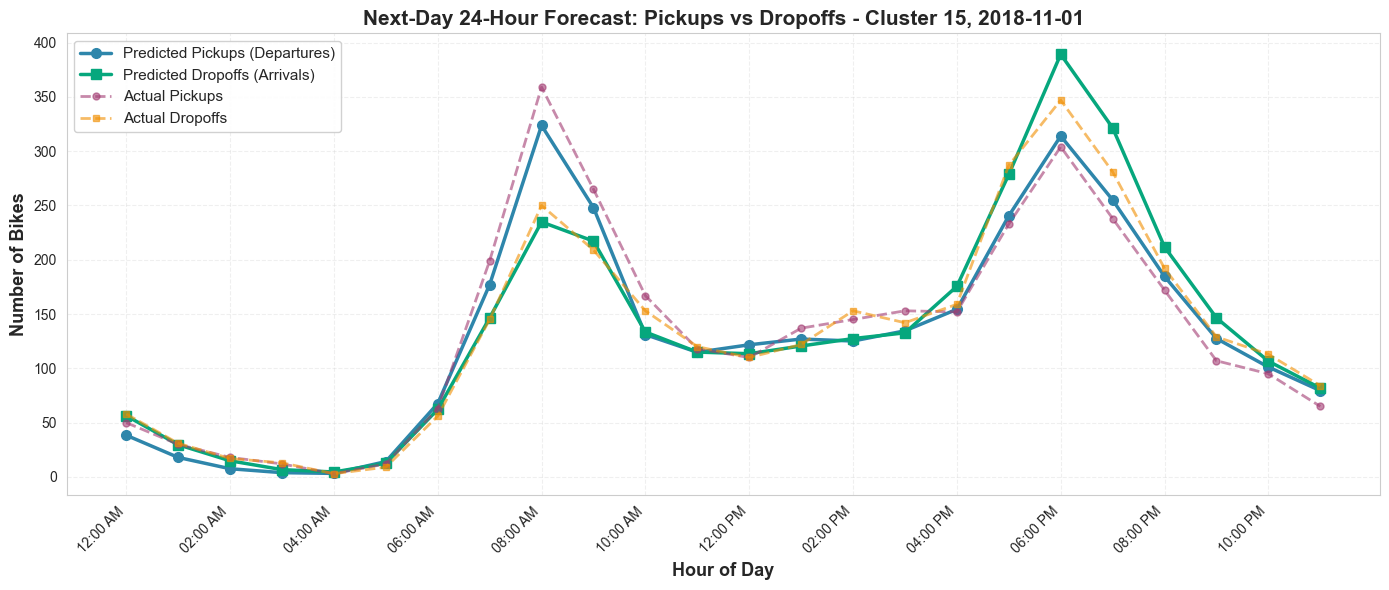

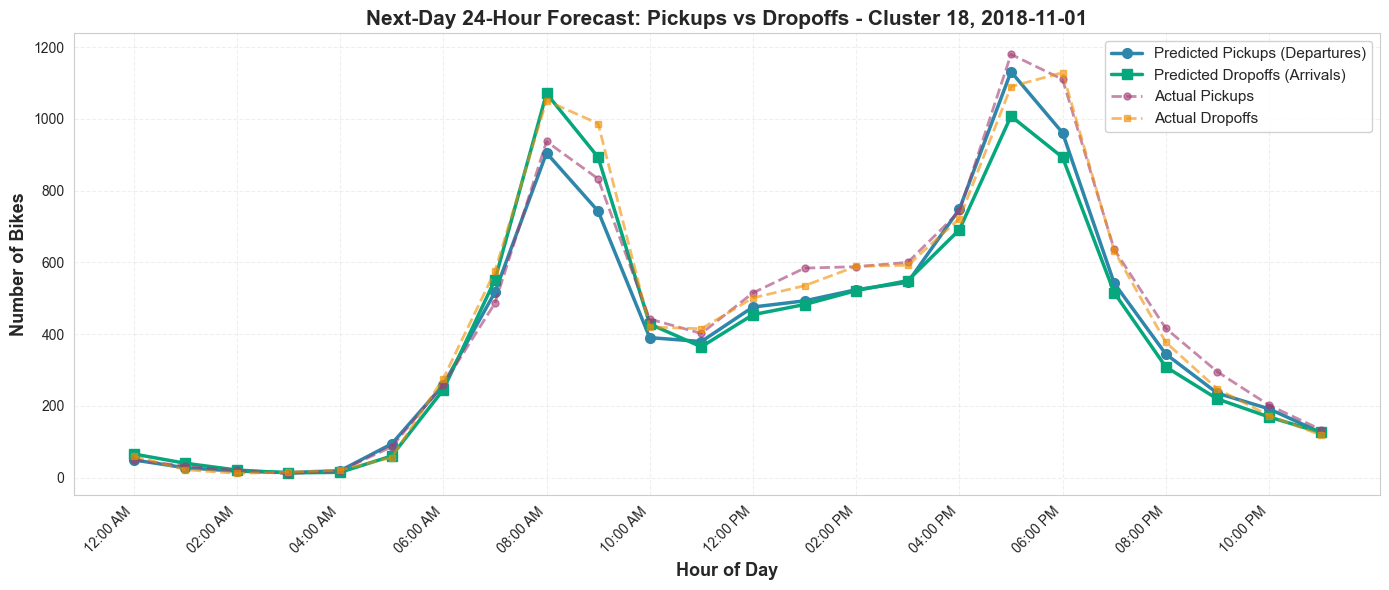

In [ ]:
# === Plot next-day 24-hour forecast for pickups and dropoffs ===
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Process both clusters
clusters_to_plot = [15, 18]

for cluster_id in clusters_to_plot:
    # Select a representative day for visualization (first forecastable day for this cluster)
    example_day = gb_daily_summary[
        (gb_daily_summary['cluster'] == cluster_id) & 
        (gb_daily_summary['flow'] == 'pickups')
    ]['forecast_day'].min()
    
    # Extract forecast data for the selected day
    forecast_day_data = gb_forecast_timeseries[
        (gb_forecast_timeseries['cluster'] == cluster_id) &
        (gb_forecast_timeseries['forecast_day'] == example_day)
    ].copy()
    
    # Separate pickups and dropoffs
    pickups_data = forecast_day_data[forecast_day_data['flow'] == 'pickups'].sort_values('timestamp')
    dropoffs_data = forecast_day_data[forecast_day_data['flow'] == 'dropoffs'].sort_values('timestamp')
    
    # Create the combined plot showing both flows together
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    
    ax.plot(pickups_data['timestamp'], pickups_data['predicted'], 
            marker='o', linewidth=2.5, markersize=7, label='Predicted Pickups (Departures)', 
            color='#2E86AB')
    ax.plot(dropoffs_data['timestamp'], dropoffs_data['predicted'], 
            marker='s', linewidth=2.5, markersize=7, label='Predicted Dropoffs (Arrivals)', 
            color='#06A77D')
    
    if 'actual' in pickups_data.columns:
        ax.plot(pickups_data['timestamp'], pickups_data['actual'], 
                marker='o', linewidth=2, markersize=5, label='Actual Pickups', 
                color='#A23B72', linestyle='--', alpha=0.6)
    if 'actual' in dropoffs_data.columns:
        ax.plot(dropoffs_data['timestamp'], dropoffs_data['actual'], 
                marker='s', linewidth=2, markersize=5, label='Actual Dropoffs', 
                color='#F18F01', linestyle='--', alpha=0.6)
    
    ax.set_xlabel('Hour of Day', fontsize=13, fontweight='bold')
    ax.set_ylabel('Number of Bikes', fontsize=13, fontweight='bold')
    # Format the date for the title
    example_day_str = pd.to_datetime(example_day).strftime('%Y-%m-%d')
    ax.set_title(f'Next-Day 24-Hour Forecast: Pickups vs Dropoffs - Cluster {cluster_id}, {example_day_str}', 
                 fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    
    # Format x-axis
    all_timestamps = sorted(set(list(pickups_data['timestamp']) + list(dropoffs_data['timestamp'])))
    ax.set_xticks(all_timestamps[::2])
    hour_labels = [ts.strftime('%I:%M %p') for ts in all_timestamps]
    ax.set_xticklabels([hour_labels[i] if i < len(hour_labels) else '' for i in range(0, len(all_timestamps), 2)], 
                       rotation=45, ha='right')

    plt.tight_layout()
    plt.show()
    


### 4.5 Next-day bike rebalancing requirements

To ensure that the bike-sharing company can meet demand for the next day, we use the outputs from our prediction model (Gradient Boosting) to compute the required number of bicycles that must be placed in each cluster at the beginning of the next day.

**Methodology:**

1. **Using Prediction Model Outputs**: For each cluster and each day in the test period (Nov–Dec 2018), we use our trained Gradient Boosting model to forecast hourly pickups (departures) and dropoffs (arrivals) for the next 24 hours.

2. **Computing Cumulative Net Departures**: For each hour of the day, we calculate the net departures as the difference between pickups and dropoffs:
   ```
   net_departures = pickups - dropoffs
   ```
   We then compute the cumulative sum of these net departures throughout the day, starting from the beginning of the day. This cumulative value represents the running balance of bikes in the cluster (positive values indicate net departures, negative values indicate net arrivals).

3. **Finding Maximum Deficit**: The goal is to ensure that, over the duration of the next day, there will never be a shortage of bikes—or, if there is, to minimize the number of bikes in deficit. To achieve this, we identify the **maximum positive cumulative net departure** across all 24 hours of the day. This maximum represents the peak deficit point—the moment when the cluster would have the greatest shortage if we started with zero bikes.

4. **Required Initial Bikes**: The number of bicycles required at the beginning of the day is equal to this maximum cumulative net departure. By starting with at least this many bikes, we ensure that:
   - The cluster never runs out of bikes during the day
   - Any deficit is minimized (ideally eliminated)
   - The system can handle the peak demand period even before later arrivals replenish the cluster

In [ ]:
if gb_forecast_timeseries.empty:
    raise ValueError("Forecast time series is empty. Re-run the previous cells to generate pickup/dropoff predictions.")

forecast_wide = (
    gb_forecast_timeseries
    .pivot_table(
        index=['cluster', 'forecast_day', 'timestamp'],
        columns='flow',
        values='predicted',
        aggfunc='mean'
    )
    .reset_index()
)
forecast_wide.columns.name = None
forecast_wide = forecast_wide.rename(columns={'pickups': 'pickups_pred', 'dropoffs': 'dropoffs_pred'})
forecast_wide[['pickups_pred', 'dropoffs_pred']] = forecast_wide[['pickups_pred', 'dropoffs_pred']].fillna(0)
forecast_wide['net_departures'] = forecast_wide['pickups_pred'] - forecast_wide['dropoffs_pred']


def compute_bike_requirement(df):
    ordered = df.sort_values('timestamp').copy()
    ordered['cum_net_departures'] = ordered['net_departures'].cumsum()
    peak_idx = ordered['cum_net_departures'].idxmax()
    peak_time = ordered.loc[peak_idx, 'timestamp']
    required_bikes = max(ordered['cum_net_departures'].max(), 0)
    return pd.Series({
        'required_start_bikes': required_bikes,
        'peak_time': peak_time,
        'daily_pickups': ordered['pickups_pred'].sum(),
        'daily_dropoffs': ordered['dropoffs_pred'].sum()
    })

bike_plan = (
    forecast_wide
    .groupby(['cluster', 'forecast_day'])
    .apply(compute_bike_requirement)
    .reset_index()
    .sort_values(['cluster', 'forecast_day'])
)

bike_plan.head()


cluster forecast_day  required_start_bikes           peak_time  \
0       15   2018-11-01            128.290770 2018-11-01 13:00:00   
1       15   2018-11-02            137.816476 2018-11-02 09:00:00   
2       15   2018-11-03             59.878692 2018-11-03 12:00:00   
3       15   2018-11-04             25.752682 2018-11-04 09:00:00   
4       15   2018-11-05            118.556397 2018-11-05 09:00:00   

   daily_pickups  daily_dropoffs  
0    3112.785026     3239.693715  
1    3090.991935     3179.823222  
2    3720.237323     3760.638309  
3    3046.362062     3346.707124  
4    2719.367583     3385.610967

In [ ]:
# Worst-case requirement per cluster across the Nov–Dec horizon
bike_plan_cluster_summary = (
    bike_plan
    .groupby('cluster')['required_start_bikes']
    .agg(['max', 'mean'])
    .rename(columns={'max': 'max_required_bikes', 'mean': 'avg_required_bikes'})
    .reset_index()
)

bike_plan_cluster_summary


cluster  max_required_bikes  avg_required_bikes
0       15          838.040353          173.410258
1       18         1152.077786          236.685928

In [ ]:
# Example recommendation for the first forecastable test day per cluster
sample_recommendations = (
    bike_plan
    .groupby('cluster')
    .first()
    .reset_index()
)

sample_recommendations


cluster forecast_day  required_start_bikes           peak_time  \
0       15   2018-11-01            128.290770 2018-11-01 13:00:00   
1       18   2018-11-01             26.067291 2018-11-01 22:00:00   

   daily_pickups  daily_dropoffs  
0    3112.785026     3239.693715  
1    9731.451732     9705.464412

#### 4.5.3 Visualization of rebalancing requirements

The following visualizations demonstrate how we compute the required number of bicycles for each cluster using cumulative arrivals and departures:
1. **Cumulative net departures calculation** - Shows how we compute the cumulative sum of (pickups - dropoffs) throughout a sample day and identify the maximum deficit point
2. **Required bikes per cluster** - Displays the final computed required number of bicycles for each cluster at the beginning of the day


Demonstrating cumulative net departures calculation for 2018-11-01



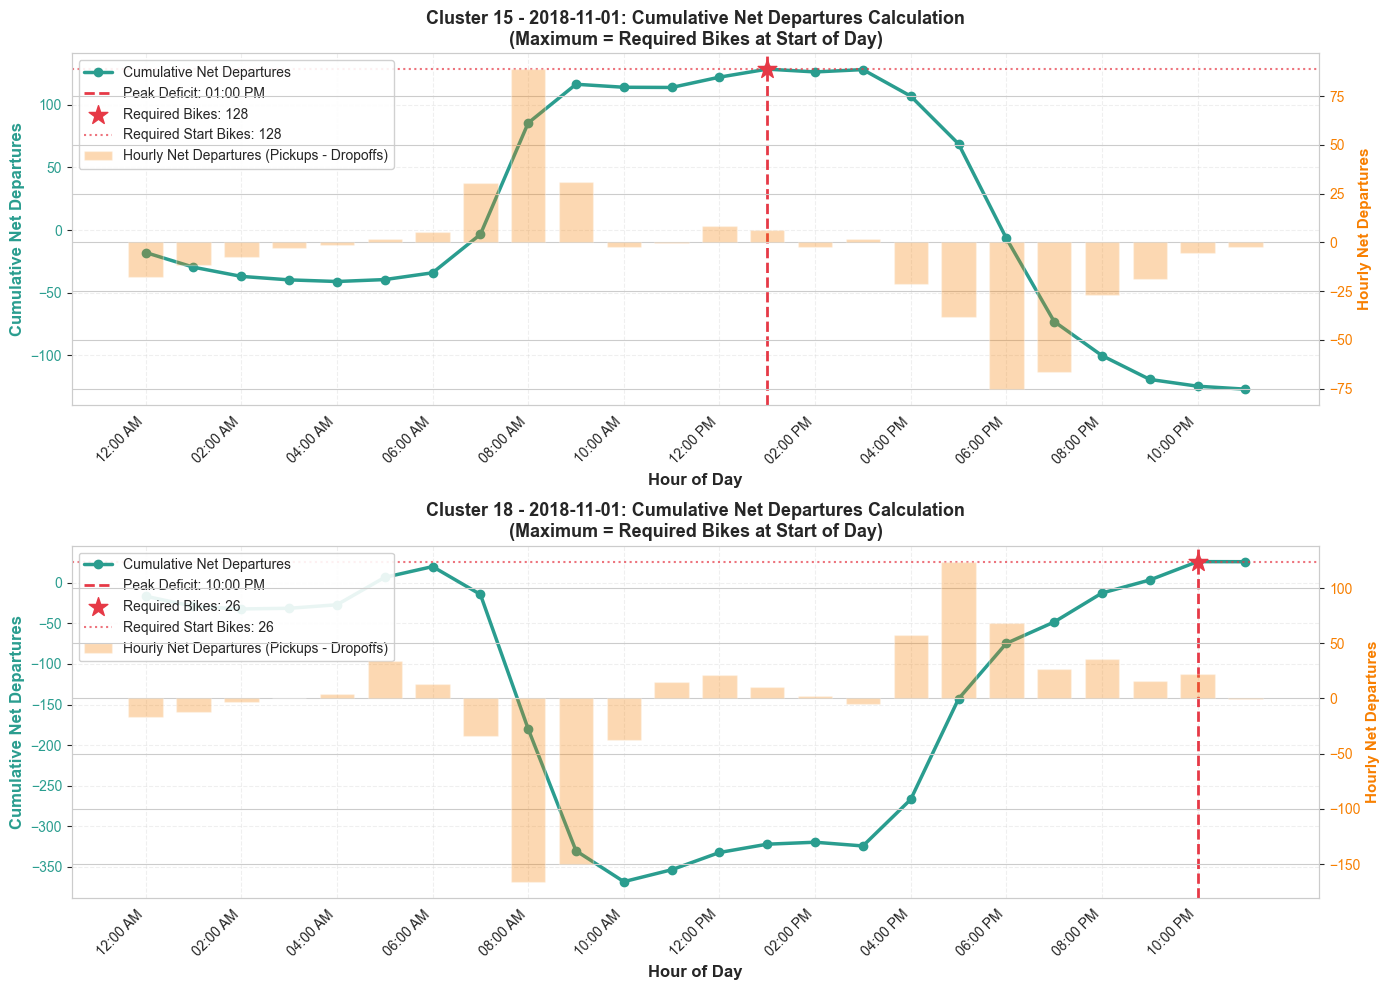

In [ ]:
# === Visualize bike rebalancing requirements ===
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure forecast_wide exists for the cumulative calculation plot
if 'forecast_wide' not in globals():
    raise ValueError("forecast_wide DataFrame is required. Please run the previous cells first.")

# === Plot 1: Cumulative net departures calculation for a sample day ===
# This demonstrates how we compute the required bikes using cumulative arrivals and departures
example_day = sample_recommendations['forecast_day'].min()
print(f"Demonstrating cumulative net departures calculation for {example_day}\n")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for idx, row in sample_recommendations.iterrows():
    cluster_id = row['cluster']
    forecast_day = row['forecast_day']
    
    # Get hourly data for this day
    day_data = forecast_wide[
        (forecast_wide['cluster'] == cluster_id) &
        (forecast_wide['forecast_day'] == forecast_day)
    ].sort_values('timestamp').copy()
    
    if day_data.empty:
        continue
    
    # Calculate cumulative net departures (this is the key calculation)
    day_data['cum_net_departures'] = day_data['net_departures'].cumsum()
    
    # Plot on separate subplot for each cluster
    ax = axes[idx]
    
    # Plot hourly net departures as bars
    ax2 = ax.twinx()
    ax2.bar(day_data['timestamp'], day_data['net_departures'], 
            alpha=0.3, color='#F77F00', label='Hourly Net Departures (Pickups - Dropoffs)', width=0.03)
    ax2.set_ylabel('Hourly Net Departures', fontsize=11, color='#F77F00', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='#F77F00')
    
    # Plot cumulative net departures (the key metric)
    ax.plot(day_data['timestamp'], day_data['cum_net_departures'], 
            marker='o', linewidth=2.5, markersize=6, 
            label='Cumulative Net Departures', color='#2A9D8F')
    
    # Mark the maximum deficit point (peak)
    peak_idx = day_data['cum_net_departures'].idxmax()
    peak_time = day_data.loc[peak_idx, 'timestamp']
    peak_value = day_data.loc[peak_idx, 'cum_net_departures']
    required_bikes = max(peak_value, 0)
    
    ax.axvline(x=peak_time, color='#E63946', linestyle='--', linewidth=2, 
               label=f'Peak Deficit: {peak_time.strftime("%I:%M %p")}')
    ax.scatter([peak_time], [peak_value], color='#E63946', s=200, zorder=5, 
              marker='*', label=f'Required Bikes: {required_bikes:.0f}')
    
    # Add horizontal line at required bikes
    ax.axhline(y=required_bikes, color='#E63946', linestyle=':', linewidth=1.5, 
              alpha=0.7, label=f'Required Start Bikes: {required_bikes:.0f}')
    
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Net Departures', fontsize=12, fontweight='bold', color='#2A9D8F')
    ax.set_title(f'Cluster {cluster_id} - {forecast_day}: Cumulative Net Departures Calculation\n(Maximum = Required Bikes at Start of Day)', 
                 fontsize=13, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='#2A9D8F')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis
    ax.set_xticks(day_data['timestamp'][::2])
    hour_labels = [ts.strftime('%I:%M %p') for ts in day_data['timestamp']]
    ax.set_xticklabels([hour_labels[i] if i < len(hour_labels) else '' 
                        for i in range(0, len(day_data), 2)], rotation=45, ha='right')
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

**Explanation of the Visualizations:**

**Plot 1: Cumulative Net Departures Calculation**

This plot demonstrates the core methodology for computing required bikes. For each cluster, it shows:

- **Hourly Net Departures (orange bars)**: The difference between pickups and dropoffs for each hour of the day (`pickups - dropoffs`). Positive values indicate more bikes leaving than arriving, while negative values indicate more bikes arriving than leaving.

- **Cumulative Net Departures (green line)**: The running sum of hourly net departures throughout the day, starting from zero at the beginning of the day. This line shows how the bike inventory balance changes over time. As the day progresses, if more bikes are picked up than dropped off, the cumulative value increases (becomes more positive), indicating a growing deficit.

- **Peak Deficit Point (red star and vertical line)**: The point in time when the cumulative net departures reach their maximum positive value. This represents the moment of greatest bike shortage during the day—the point where the cluster would have the most bikes missing if we started with zero bikes.

- **Required Bikes (red horizontal line)**: The maximum cumulative net departure value, which equals the number of bikes that must be placed at the cluster at the beginning of the day. By starting with at least this many bikes, we ensure that the cluster never runs out of bikes, even at the peak deficit moment.

**Key Insight**: The required number of bikes is determined by finding the maximum positive cumulative net departure across all 24 hours. This ensures that even during the worst-case scenario (peak deficit), there will always be enough bikes available.

**Plot 2: Required Bikes per Cluster**

This bar chart displays the final computed required number of bicycles for each cluster. The values shown represent the maximum required bikes across all days in the test period (Nov–Dec 2018), ensuring that each cluster is prepared for the worst-case scenario. These numbers are the direct answer to the rebalancing task: they tell the bike-sharing company exactly how many bikes need to be positioned at each cluster at the start of each day to prevent shortages.


#### 4.5.4 Time Series: Daily Required Bikes for Next Month

The following time series plot shows the daily required number of bicycles that need to be placed in each cluster at the beginning of each day to ensure demand is fulfilled throughout that day. This provides a forward-looking view of bike rebalancing requirements.


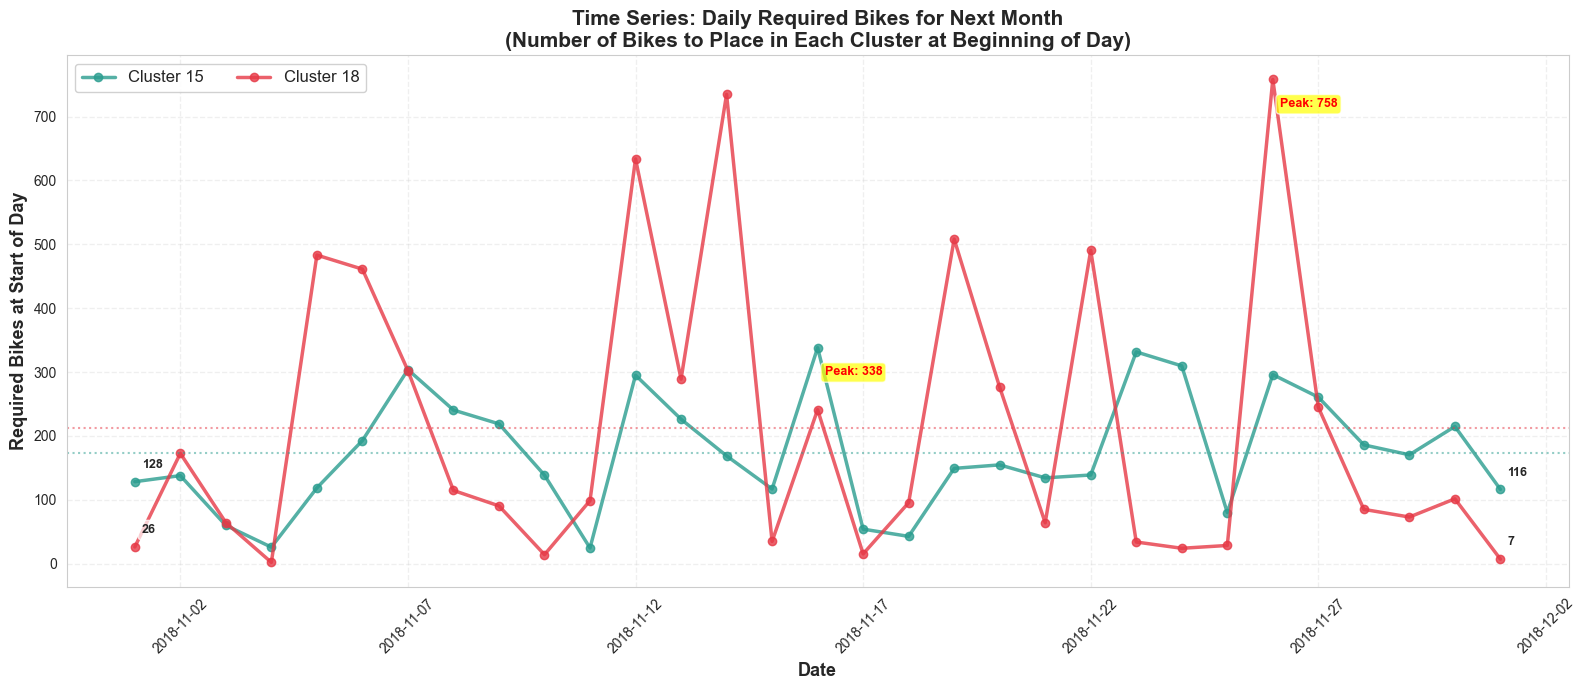


MONTHLY SUMMARY: Required Bikes per Cluster

Period: 2018-11-01 to 2018-12-01
Total days: 31

Cluster 15:
  • Minimum required: 25 bikes
  • Maximum required: 338 bikes
  • Average required: 173.3 bikes
  • Standard deviation: 91.5 bikes
  • Total bikes needed (sum): 5372 bikes

Cluster 18:
  • Minimum required: 2 bikes
  • Maximum required: 758 bikes
  • Average required: 211.8 bikes
  • Standard deviation: 226.9 bikes
  • Total bikes needed (sum): 6567 bikes



In [ ]:
# === Time Series Plot: Daily Required Bikes for Next Month ===
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Ensure bike_plan exists
if 'bike_plan' not in globals():
    raise ValueError("bike_plan DataFrame is required. Please run the previous cells first.")

# Convert forecast_day to datetime if needed
bike_plan['forecast_day'] = pd.to_datetime(bike_plan['forecast_day'])

# Sort by date
bike_plan_sorted = bike_plan.sort_values(['cluster', 'forecast_day']).copy()

# Get the first 30 days (approximately 1 month) of predictions
first_date = bike_plan_sorted['forecast_day'].min()
last_date = first_date + timedelta(days=30)
bike_plan_month = bike_plan_sorted[bike_plan_sorted['forecast_day'] <= last_date].copy()

# Create the time series plot
fig, ax = plt.subplots(1, 1, figsize=(16, 7))

# Plot for each cluster
colors = ['#2A9D8F', '#E63946', '#F77F00', '#06A77D', '#457B9D']
for idx, cluster_id in enumerate(sorted(bike_plan_month['cluster'].unique())):
    cluster_data = bike_plan_month[bike_plan_month['cluster'] == cluster_id].copy()
    
    # Plot the time series
    ax.plot(cluster_data['forecast_day'], cluster_data['required_start_bikes'], 
            marker='o', linewidth=2.5, markersize=6, 
            label=f'Cluster {cluster_id}', 
            color=colors[idx % len(colors)], 
            alpha=0.8)
    
    # Add value labels for key points (first day, last day, and peak)
    if not cluster_data.empty:
        # First day
        first_row = cluster_data.iloc[0]
        ax.annotate(f'{first_row["required_start_bikes"]:.0f}', 
                   xy=(first_row['forecast_day'], first_row['required_start_bikes']),
                   xytext=(5, 10), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        # Last day
        last_row = cluster_data.iloc[-1]
        ax.annotate(f'{last_row["required_start_bikes"]:.0f}', 
                   xy=(last_row['forecast_day'], last_row['required_start_bikes']),
                   xytext=(5, 10), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        # Peak day (maximum required bikes)
        peak_row = cluster_data.loc[cluster_data['required_start_bikes'].idxmax()]
        ax.annotate(f'Peak: {peak_row["required_start_bikes"]:.0f}', 
                   xy=(peak_row['forecast_day'], peak_row['required_start_bikes']),
                   xytext=(5, -20), textcoords='offset points',
                   fontsize=9, fontweight='bold', color='red',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Formatting
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Required Bikes at Start of Day', fontsize=13, fontweight='bold')
ax.set_title('Time Series: Daily Required Bikes for Next Month\n(Number of Bikes to Place in Each Cluster at Beginning of Day)', 
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='best', framealpha=0.9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax.tick_params(axis='x', rotation=45)

# Format x-axis dates
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=5))

# Add a horizontal line showing the average required bikes
for cluster_id in sorted(bike_plan_month['cluster'].unique()):
    cluster_data = bike_plan_month[bike_plan_month['cluster'] == cluster_id]
    avg_bikes = cluster_data['required_start_bikes'].mean()
    ax.axhline(y=avg_bikes, color=colors[sorted(bike_plan_month['cluster'].unique()).index(cluster_id) % len(colors)], 
              linestyle=':', linewidth=1.5, alpha=0.5, 
              label=f'Cluster {cluster_id} Avg: {avg_bikes:.0f}')

plt.tight_layout()
plt.show()

# Print summary statistics for the month
print("\n" + "="*70)
print("MONTHLY SUMMARY: Required Bikes per Cluster")
print("="*70)
print(f"\nPeriod: {first_date.strftime('%Y-%m-%d')} to {bike_plan_month['forecast_day'].max().strftime('%Y-%m-%d')}")
print(f"Total days: {len(bike_plan_month['forecast_day'].unique())}")

for cluster_id in sorted(bike_plan_month['cluster'].unique()):
    cluster_data = bike_plan_month[bike_plan_month['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  • Minimum required: {cluster_data['required_start_bikes'].min():.0f} bikes")
    print(f"  • Maximum required: {cluster_data['required_start_bikes'].max():.0f} bikes")
    print(f"  • Average required: {cluster_data['required_start_bikes'].mean():.1f} bikes")
    print(f"  • Standard deviation: {cluster_data['required_start_bikes'].std():.1f} bikes")
    print(f"  • Total bikes needed (sum): {cluster_data['required_start_bikes'].sum():.0f} bikes")

print("\n" + "="*70)
